<a href="https://colab.research.google.com/github/Benjabby/CE888-Resit/blob/master/CE888_Resit_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier, Perceptron
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.dummy import DummyClassifier
from scipy import interp

In [ ]:
%%capture
!pip install modAL
!pip install umap-learn[plot]
import os
import modAL as al
from modAL import batch as alb
import sklearn as sk
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import pickle as pk
import gc
#import umap
#import umap.plot as up
SEED = 0xDDDDDDDD
np.random.seed(SEED)


# Classes & Utility Functions

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
# def most_likely_fraud(classifier, X, **predict_proba_kwargs) -> np.ndarray:
#   try:
#       proba = classifier.predict_proba(X, **predict_proba_kwargs)
#   except NotFittedError:
#       return np.ones(shape=(X.shape[0], ))

#   where_one_be = classifier.estimator.classes_.tolist().index(1)
#   likely = proba[:,where_one_be]
#   return likely


# def most_likely_fraud_strategy(classifier, n_instances=1, random_tie_break: bool = False, modALisbroken=1, **uncertainty_measure_kwargs):

#   uncertainty = most_likely_fraud(classifier, X, **uncertainty_measure_kwargs)

#   if not random_tie_break:
#       query_idx = al.utils.selection.multi_argmax(uncertainty, n_instances=modALisbroken)
#   else:
#       query_idx = al.utils.selection.shuffled_argmax(uncertainty, n_instances=modALisbroken)

#   return query_idx, X[query_idx]

In [ ]:
class ExperimentManager():
  def __init__(self, X, y, dataset_name, scalable_cols=None, n_pca=None, base_models=None, n_query_iter=20, query_batch=50, cv_folds=10, seed=SEED, committee_size=5):
    self.name = dataset_name
    self.X = X
    self.y = y
    self.seed = seed
    self.rng = np.random.RandomState()
    self.__reset_rng()
    self.committee_size = committee_size
    '''
    List containing tuples of cv-split indices of the format (X_raw, X_test, y_raw, y_test, start indices, pool indices)
    '''
    self.splits = []

    # Create cross validation splits. Each split should be treated independently as if it was the whole dataset
    # Scaling is applied independently per fold, fit using only the train split of the fold (X_raw) and then applied to the test split (X_test)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    #cv = KFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    for train_i, test_i in cv.split(self.X, self.y):
      X_raw, y_raw = self.X[train_i], self.y[train_i]
      X_test, y_test = self.X[test_i], self.y[test_i]

      if scalable_cols is not None:
        scaler = RobustScaler()
        if scalable_cols == 'all':
          X_raw = scaler.fit_transform(X_raw)
          X_test = scaler.transform(X_test)
        else:
          X_raw[:, scalable_cols] = scaler.fit_transform(X_raw[:, scalable_cols])
          X_test[:, scalable_cols] = scaler.transform(X_test[:, scalable_cols])

      if n_pca is not None:
        pca = PCA(n_components=n_pca)
        X_raw = pca.fit_transform(X_raw)
        X_test = pca.transform(X_test)

      # It is a safe assumption to make that in the initial labeled pool there will be at least 1 fraud example.
      # One sample is randomly chosen to be the positive example, and the amount of negative samples is chosen based on the class imbalance. These make up the initial labeled pool for each split
      # This simulates a smaller labeled dataset similar enough to the underlying distribution but guarantees there is a positive example. I hope this is reflective enough of an actual scenario
      pos = np.argwhere(y_raw==1).flatten()
      neg = np.argwhere(y_raw==0).flatten()

      pos_size = pos.shape[0]
      neg_size = neg.shape[0]

      sample_neg = np.clip(int(neg_size/pos_size),X_raw.shape[1],neg_size)

      start_i = np.concatenate([self.rng.choice(pos,1,replace=False), self.rng.choice(neg,sample_neg,replace=False)]).flatten()
      pool_i = np.delete(np.arange(X_raw.shape[0]),start_i)

      self.splits.append((X_raw, X_test, y_raw, y_test, start_i, pool_i))


    # Do not train.
    # self.base_models = [ExtraTreesClassifier(n_estimators=10, n_jobs=-1), LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto'), SGDClassifier(loss='log', fit_intercept=False)] if base_models is None else base_models.values()
    # self.base_model_names = ['Extra Forest', 'LDA', 'SGD'] if base_models is None else base_models.keys()
    self.base_models = [ExtraTreesClassifier(n_estimators=10, n_jobs=-1), SGDClassifier(loss='log',penalty='l1'), GaussianNB(), MLPClassifier(hidden_layer_sizes=(10,)), DummyClassifier(strategy='prior')] if base_models is None else base_models.values()
    self.base_model_names = ['Extra Forest', 'Logistic SGD', 'Naive Bayes', 'MLP', 'Dummy'] if base_models is None else base_models.keys()


    self.M = len(self.base_models)
    self.F = cv_folds
    self.K = n_query_iter + 1
    self.batch = query_batch

    '''
    experiments format: {'Experiment1':results1, 'Experiment2':results2, 'ExperimentN':resultsN}

    results format: numpy array of shape (M, F, K, V) where
    M is the number of models the experiment manager is testing, corresponding to the order of self.base_models & self.base_model_names - Per experiment manager
    F is the number of cross validation folds tested                                                                                    - Per experiment manager
    K is the number of active learning queries performed (e.g how many new samples are labeled) + 1 for the initial pool query.         - Per experiment
    V is 5, containing [spent budget, TN, FP, FN, TP]                                                                                   - Fixed

    Thus a value at results1[m,f,k] represents the confusion matrix values for for Experiment1 on model m, using fold f, after k queries.
    '''
    self.experiments = {}
    # The predictions and prediction probabilities of the FINAL MODEL (no point keeping all)
    # Everything else can be derived from these (and the true values which are in splits)
    # Can't use numpy array per experiment as the test size may be different between folds. 
    self.final_preds = {}
    self.final_probas = {}

    self.baseline = []
    # self.final_models = {}
    # self.runtimes = {}

  def __reset_rng(self):
    self.rng.seed(self.seed)

  def run_baseline(self):

  
  def run_experiment_test(self, experiment='random', queries=None, verbose=False):
    '''
    '''
    
    loading_bar = display(progress(0, self.M*self.F*self.K), display_id=True)
    
    results = np.zeros((self.M,self.F,self.K,4))
    #self.experiments[experiment] = np.zeros((self.M,self.F,self.K,4))
    preds = []
    probas = []

    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      model_preds = []
      model_probas = []
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_raw, X_test, y_raw, y_test, start_i, pool_i = split

        X_train, X_pool = X_raw[start_i], X_raw[pool_i]
        y_train, y_pool = y_raw[start_i], y_raw[pool_i]
        
        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)
        
        if experiment=='uncertainty':
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.uncertainty_sampling)
        # elif experiment=='uncertainty batched':
        #   learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=alb.uncertainty_batch_sampling)
        #   query_index, _ = learner.query(X_pool, n_instances=self.batch*self.K, n_jobs=-1)

            # Margin equates almost exactly to uncertainty in these cases so it is omitted.
            
        # elif experiment=='margin':
        #   learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.margin_sampling)
        elif experiment=='entropy':
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=al.uncertainty.entropy_sampling)
        # elif experiment=='fraudish':
        #   learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train, query_strategy=most_likely_fraud_strategy)
        elif experiment=='consensus' or experiment=='disagreement':
          committee = []
          for c in range(self.committee_size):
            clf = sk.base.clone(base)
            if 'random_state' in clf.get_params().keys():
              clf.set_params(random_state=(self.seed+c)%np.iinfo(np.uint32).max)
            committee.append(al.ActiveLearner(clf, X_training=X_train, y_training=y_train))#, bootstrap_init=True))
          if experiment=='consensus':
            learner = al.Committee(committee,al.disagreement.consensus_entropy_sampling)
          else:
            learner = al.Committee(committee,al.disagreement.max_disagreement_sampling)
          # Teach it the singular positive example incase it got replaced by bootstrap.
          # solo = y_train==1
          # learner.teach(X_train[solo].reshape(1, -1), y_train[solo].reshape(1, ))
        else:
          learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)
        # self.experiments[experiment][m,f,0] = confusion_matrix(y_test, pred).ravel()
        results[m,f,0] = confusion_matrix(y_test, pred).ravel()

        loading_bar.update(progress(m*self.F*self.K+f*self.K+1,self.M*self.F*self.K))
        if verbose:
          print("Unqueried", end=" | ")


        #if experiment!='uncertainty batched':
        for k in range(1,self.K):
          if experiment=='random':
            query_index = self.rng.choice(np.arange(X_pool.shape[0]), self.batch)
          elif experiment=='fraudish':
            #query_index, _ = learner.query(X_pool, modALisbroken=self.batch)
            proba = clf.predict_proba(X_pool)
            where_one_be = clf.classes_.tolist().index(1)
            likely = proba[:,where_one_be]
            query_index = al.utils.selection.multi_argmax(likely, n_instances=self.batch)
          else:
            query_index, _ = learner.query(X_pool, n_instances=self.batch)

          X, y = X_pool[query_index].reshape(self.batch, -1), y_pool[query_index].reshape(self.batch, )
          
          # if experiment=='consensus' or experiment=='disagreement':
          #   learner.teach(X=X, y=y, bootstrap=True)
          # else:
          learner.teach(X=X, y=y)

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)
          #self.experiments[experiment][m,f,k] = confusion_matrix(y_test, pred).ravel()
          results[m,f,k] = confusion_matrix(y_test, pred).ravel()

          loading_bar.update(progress(m*self.F*self.K+f*self.K+k+1,self.M*self.F*self.K))
          if verbose:
            print(k, end=", ")
        # else:
        #   for k in range(0,self.K-1):
        #     current = query_index[k*self.batch:(k+1)*self.batch]
        #     X, y = X_pool[query_index].reshape(self.batch, -1), y_pool[query_index].reshape(self.batch, )
        #     learner.teach(X=X, y=y)
        #     pred = learner.predict(X_test)
        #     results[m,f,k] = confusion_matrix(y_test, pred).ravel()

        #     loading_bar.update(progress(m*self.F*self.K+f*self.K+k+2,self.M*self.F*self.K))
        #     if verbose:
        #       print(k+1, end=", ")

          
        if verbose:
          print("DONE")
        model_preds.append(learner.predict(X_test))
        model_probas.append(learner.predict_proba(X_test)[:,1])
        f += 1
      m +=1
      preds.append(model_preds)
      probas.append(model_probas)
    
    self.experiments[experiment] = results
    self.final_preds[experiment] = preds
    self.final_probas[experiment] = probas


  # TODO. Finish properly
  def get_result(self, experiment=None, metric=None, queries='all', fold=None, include_std=False, model='all'):
    if experiment is None: 
      print("experiment=None is currently unsupported")
      return

    result = self.experiments[experiment]

    #dim_names = np.array(['Experiment','Model','Fold','Kth-Query','Confusion Values'])

    # #result_dict
    if metric is not None:
      TN, FP, FN, TP = result[...,0], result[...,1], result[...,2], result[...,3]
      if metric=='tn': result = TN
      elif metric=='fp': result = FP
      elif metric=='fn': result = FN
      elif metric=='tp': result = TP
      elif metric=='recall': result = TP/(TP+FN)
      elif metric=='precision': result = TP/(TP+FP)
      elif metric=='mcc': result = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
      elif metric=='f1': result = TP/(TP+0.5*(FP+FN))
      elif metric=='normalized_confusion': 
        result[...,:2] /= (TN+FP)
        result[...,2:] /= (TP+FN)

      if result.ndim<4:
        result = np.expand_dims(result,-1)

    if model is None or model=='avg':
      result = np.mean(result, axis=0, keepdims=True)
    if fold is None or fold=='avg':
      result = np.mean(result, axis=1, keepdims=True)
    if queries is None or queries=='last':
      result = result[:,:,-1,np.newaxis,:]
    
    return result

  def get_precision_recall_curves(self, experiment=None, model='all', include_std=False, return_auc=False):
    if experiment is None: 
      print("experiment=None is currently unsupported")
      return
    if model != 'all': 
      print("model!='all' is currently unsupported")
      return

    probas = self.final_probas[experiment]

    base_rec = np.linspace(0, 1, 101)

    curves = []
    aucs = []

    for m, name in enumerate(self.base_model_names):
      pres = []
      maucs = []
      for f, (split) in enumerate(self.splits):
        y_test = split[3]
        y_score = probas[m][f]
        pre, rec, _ = precision_recall_curve(y_test, y_score)
        maucs.append(auc(rec,pre))
        pre = interp(base_rec, pre, rec)
        pre[0] = 1.0
        pres.append(pre)
        
      pres = np.array(pres)
      mean_pres = pres.mean(axis=0)

      maucs = np.array(maucs)
      mean_maucs = maucs.mean(axis=0)

      if include_std:
        std = pres.std(axis=0)
        upper = np.minimum(mean_pres + std, 1)
        lower = mean_pres - std
        curves.append((mean_pres,lower,upper))
        std = maucs.std(axis=0)
        aucs.append((mean_maucs,std))
      else:
        curves.append(mean_pres)
        aucs.append(mean_maucs)
    
    if return_auc:
      return curves, aucs
    else:
      return curves

###### Tests

In [ ]:
names = [
         "Passive Aggressive",
         "Bag AA",
         "Bag AB",
         "Bag BA",
         "Bag BB",
         "SGD Log", "SGD  Elastoplast", "SGD Huber a", "SGD Huber b","Decision Tree Full", "Extra Forest Full 10", "QDA", "LDA", "Naive Bayes","MLP"]

classifiers = [
               PassiveAggressiveClassifier(),
    BaggingClassifier(bootstrap=False, bootstrap_features=False, n_jobs=-1),
    BaggingClassifier(bootstrap=True, bootstrap_features=False, n_jobs=-1),
    BaggingClassifier(bootstrap=False, bootstrap_features=True, n_jobs=-1),
    BaggingClassifier(bootstrap=True, bootstrap_features=True, n_jobs=-1, ),
    SGDClassifier(loss='log',penalty='l1'),
    SGDClassifier(loss='log',penalty='elasticnet'),
    SGDClassifier(loss='modified_huber',penalty='l1'),
    SGDClassifier(loss='modified_huber',penalty='elasticnet'),
    DecisionTreeClassifier(),
    #RandomForestClassifier(n_estimators=10),
    #RandomForestClassifier(n_estimators=50),
    #RandomForestClassifier(max_depth=5),
    #RandomForestClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    #ExtraTreesClassifier(max_depth=5),
    #ExtraTreesClassifier(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto'),
    GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #SGDClassifier(),
    MLPClassifier(hidden_layer_sizes=(10,)),
    
]

Q, q = RobustScaler().fit_transform(X), y
J, j = RobustScaler().fit_transform(X), y

for name, clf in zip(names, classifiers):
  t = time.perf_counter()
  clf.fit(Q, q)
  pred = clf.predict(J)
  print("{n} time: {t:.5f}".format(n=name,t=(time.perf_counter()-t)))
  score = sk.metrics.f1_score(j,pred)
  print("F1: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.matthews_corrcoef(j,pred)
  print("MCC: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.roc_auc_score(j,pred)
  print("AUC: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.balanced_accuracy_score(j,pred)
  print("Balanced: {v:.3f}".format(n=name,v=score))
  print()

Passive Aggressive time: 0.54704
F1: 0.802
MCC: 0.801
AUC: 0.896
Balanced: 0.896



KeyboardInterrupt: ignored

In [ ]:
names = [
         #"Passive Aggressive",
         #"Logistic",
         #"Logelastic",
         #"LogisticNone",
         #"Bag AA",
         #"Bag AB",
         #"Bag BA",
         #"Bag BB",
         #"Linear SVC B",
         #"Bagged SVC",
         #"Decision Tree",
         #"Decision Tree Balanced",
         #"Decision Tree Entropy",
         #"Decision Tree Entropy Balanced",
         #"Extra Tree Balanced",
         #"Decision Tree CCP",
         #"Decision Tree Split Lim",
         #"Ada",
         #"Gradient 10",
         "Naive Bayes",
         "Complement Bayes",
         "Complement Bayes 2",
         "Perceptron",
         #"MLP Adam",
         "MLP Adam Smaller"
         #"Gradient 50"
         #"Random Forest Full 10",
         #"Random Forest Full 50",
         #"Random Forest Gimped 100",
         #"Extra Forest Full 10",
         #"Extra Forest Gimped 100",
         #"QDA",
         #"Naive Bayes",
         #"LDA",
         #"SGD",
         #"Isolation 10",
         #"Isolation 100",
         #"SGD Percep",
         #"QDA Reg",
         #"LDA LSqr",
         #"LDA Eigen"
         #"KNN",
         #"KNN Radius"
         ]

classifiers = [
    #PassiveAggressiveClassifier(n_iter_no_change=20),
    #LogisticRegression(solver='sag',max_iter=500),
    #LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.5),
    #LogisticRegression(solver='saga',penalty='none'),
    #BaggingClassifier(bootstrap=False, bootstrap_features=False, n_jobs=-1),
    #BaggingClassifier(bootstrap=True, bootstrap_features=False, n_jobs=-1),
    #BaggingClassifier(bootstrap=False, bootstrap_features=True, n_jobs=-1),
    #BaggingClassifier(bootstrap=True, bootstrap_features=True, n_jobs=-1, ),
    #LinearSVC(class_weight='balanced', fit_intercept=False),
    #BaggingClassifier(SVC(class_weight='balanced'), max_samples= 1.0 / 10, n_estimators=10, n_jobs=-1),
    #DecisionTreeClassifier(max_depth=10),
    #DecisionTreeClassifier(max_depth=10,class_weight='balanced'),
    #DecisionTreeClassifier(criterion='entropy'),
    #DecisionTreeClassifier(max_depth=10,criterion='entropy',class_weight='balanced'),
    #ExtraTreesClassifier(n_estimators=10,class_weight='balanced'),
    #DecisionTreeClassifier(ccp_alpha=0.01),
    #DecisionTreeClassifier(min_samples_split=0.01,class_weight='balanced'),
    #AdaBoostClassifier(n_estimators=10),
    #GradientBoostingClassifier(n_estimators=10, subsample=0.1, max_features='auto'),
    GaussianNB(),
    ComplementNB(),
    ComplementNB(norm=True),
    Perceptron(max_iter=2000,class_weight='balanced'),
    #MLPClassifier(hidden_layer_sizes=(20,20,)),
    MLPClassifier(hidden_layer_sizes=(10,)),
    #MLPClassifier(hidden_layer_sizes=(20,20,),solver='sgd',learning_rate='adaptive'),
    #GradientBoostingClassifier(n_estimators=50)
    #RandomForestClassifier(n_estimators=10),
    #RandomForestClassifier(n_estimators=50),
    #RandomForestClassifier(max_depth=5),
    #RandomForestClassifier(),
    #ExtraTreesClassifier(n_estimators=10),
    #ExtraTreesClassifier(max_depth=5),
    #ExtraTreesClassifier(),
    #QuadraticDiscriminantAnalysis(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #SGDClassifier(n_iter_no_change=20, max_iter=5000),
    #IsolationForest(n_estimators=10,),
    #IsolationForest(),
    #SGDClassifier(loss='perceptron',max_iter=5000),
    #QuadraticDiscriminantAnalysis(reg_param=0.5),
    #LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto'),
    #LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')
    #KNeighborsClassifier(leaf_size=15),
    #RadiusNeighborsClassifier(leaf_size=15)
]

Q, q = X[A], y[A]
J, j = X[B], y[B]

for name, clf in zip(names, classifiers):
  t = time.perf_counter()
  if "Complement" in name:
    l = sk.preprocessing.MinMaxScaler()
    clf.fit(l.fit_transform(Q),q)
    pred = clf.predict(l.transform(J))
  elif "Naive" in name:
    clf.fit(Q, q, sample_weight=sk.utils.class_weight.compute_sample_weight('balanced',q))
    pred = clf.predict(J)
  else:
    clf.fit(Q, q)
    pred = clf.predict(J)
  
  print("{n} time: {t:.5f}".format(n=name,t=(time.perf_counter()-t)))
  score = sk.metrics.f1_score(j,pred)
  print("F1: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.matthews_corrcoef(j,pred)
  print("MCC: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.roc_auc_score(j,pred)
  print("AUC: {v:.3f}".format(n=name,v=score))
  score = sk.metrics.balanced_accuracy_score(j,pred)
  print("Balanced: {v:.3f}".format(n=name,v=score))
  print()

NameError: ignored

# NEW

## Dataset 1: ULB

In [ ]:
os.environ['KAGGLE_USERNAME'] = "benjabby"
os.environ['KAGGLE_KEY'] = "a3e17634697e026f4396489db1115b71"

!mkdir ulb
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip -d ulb
!rm creditcardfraud.zip

mkdir: cannot create directory ‘ulb’: File exists
 86% 57.0M/66.0M [00:01<00:00, 48.7MB/s]
100% 66.0M/66.0M [00:01<00:00, 59.3MB/s]
Archive:  creditcardfraud.zip
replace ulb/creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ulb = pd.read_csv('/content/ulb/creditcard.csv')

In [ ]:
ulb.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There are no missing values

In [ ]:
ulb.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The classes are highly imbalanced, but this is to be expected for the problem

In [ ]:
pd.value_counts(ulb.Class)

0    284315
1       492
Name: Class, dtype: int64

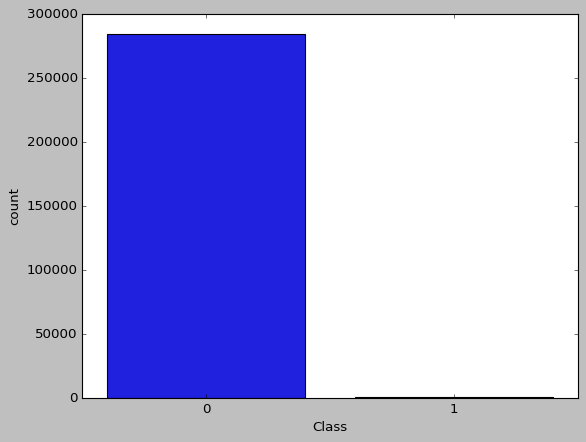

In [ ]:
sns.countplot('Class',data=ulb)

### Experimental Setup

All features except time and amount are already scaled.
Scaling will take place inside the CV folds

In [ ]:
X_df = ulb.drop(columns=['Class'])
y_df = ulb.Class
scale_cols = [X_df.columns.get_loc(c) for c in ['Amount','Time'] if c in X_df]
X = X_df.values
y = y_df.values

manager = ExperimentManager(X,y,'ULB',scalable_cols=scale_cols)

samplers = ['random','uncertainty','entropy','fraudish']#'consensus','disagreement']

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### Random Sampling

In [ ]:
if 'random' not in manager.experiments:
  manager.run_experiment_test('random')

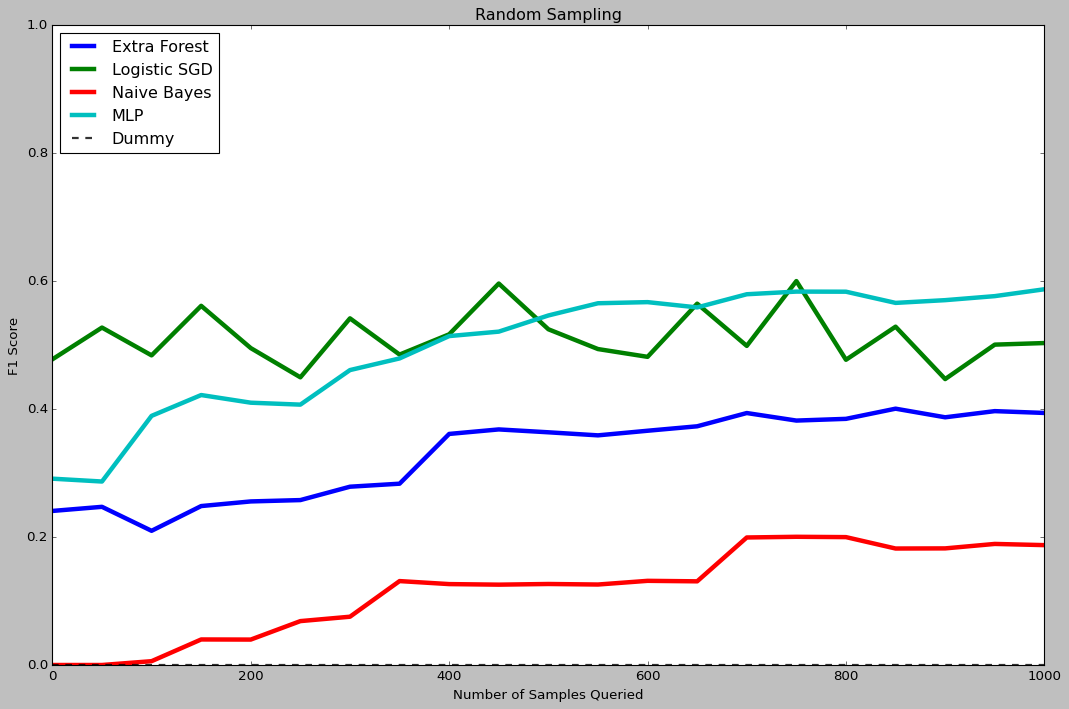

In [ ]:
V = manager.get_result("random",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Random Sampling")
plt.legend(loc='upper left')
plt.show()

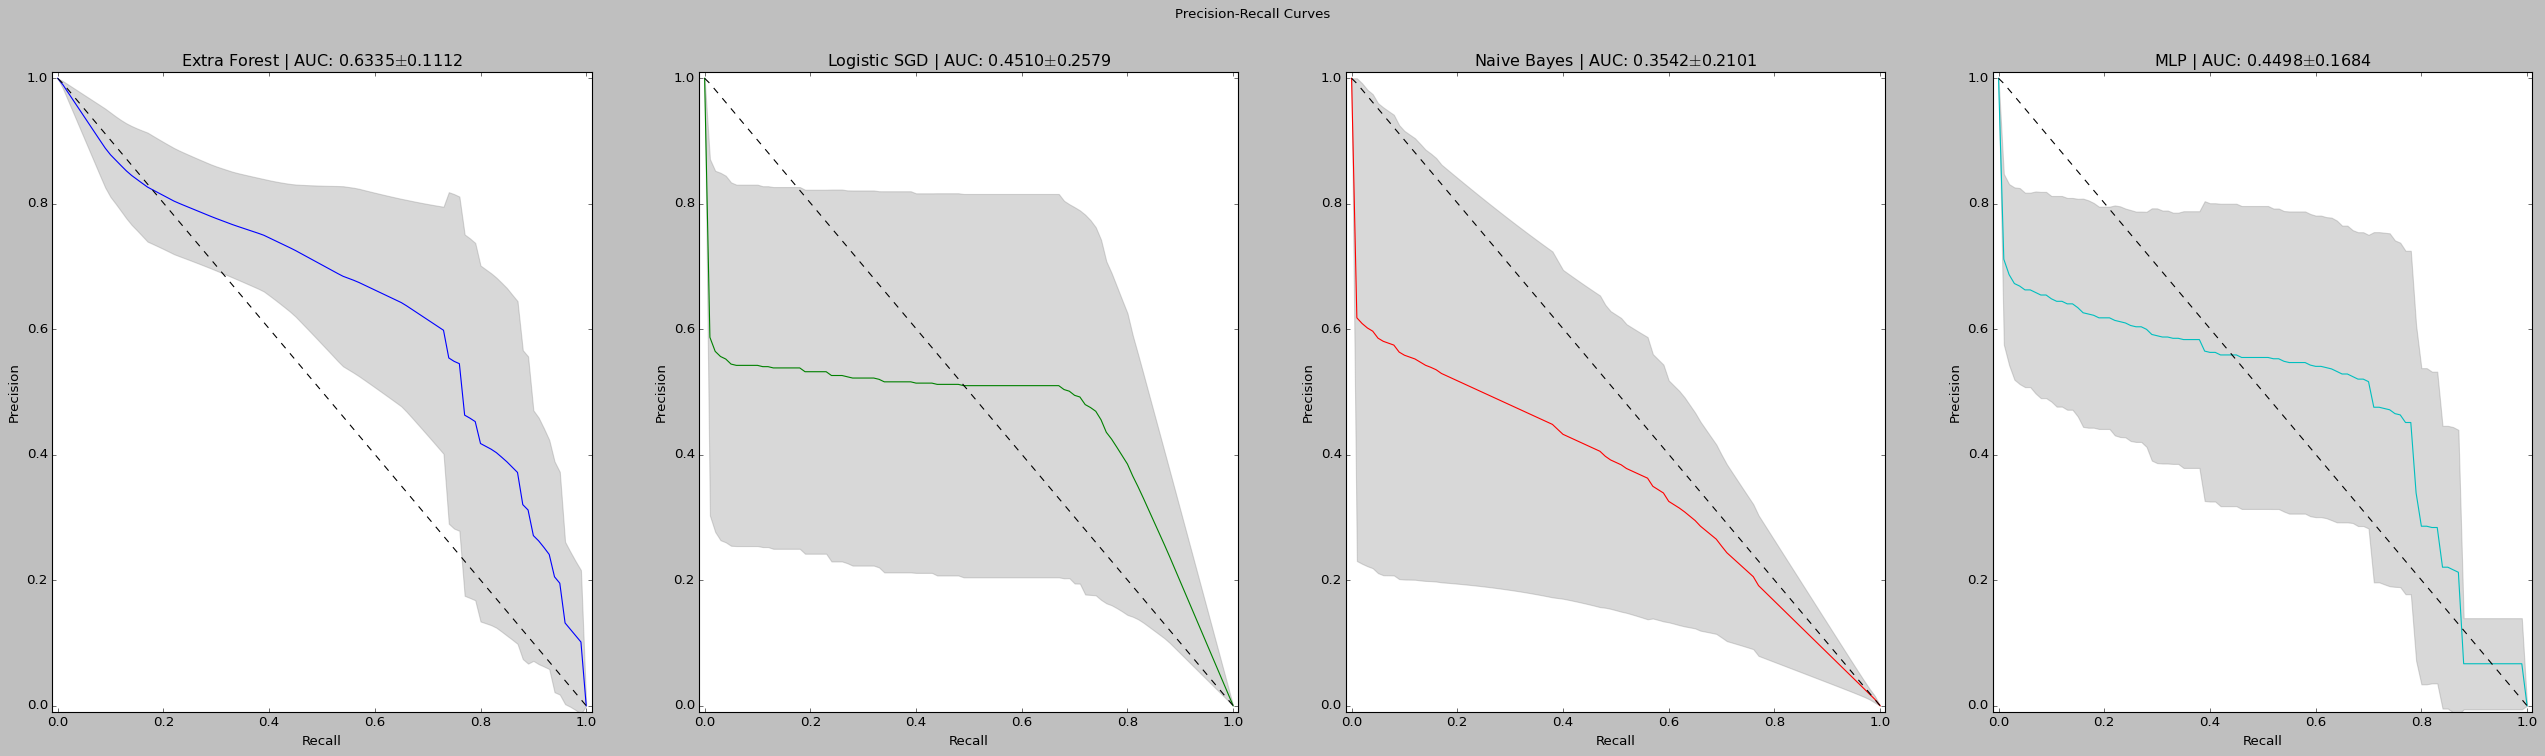

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='random', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Uncertainty Sampling

In [ ]:
if 'uncertainty' not in manager.experiments:
  manager.run_experiment_test('uncertainty')

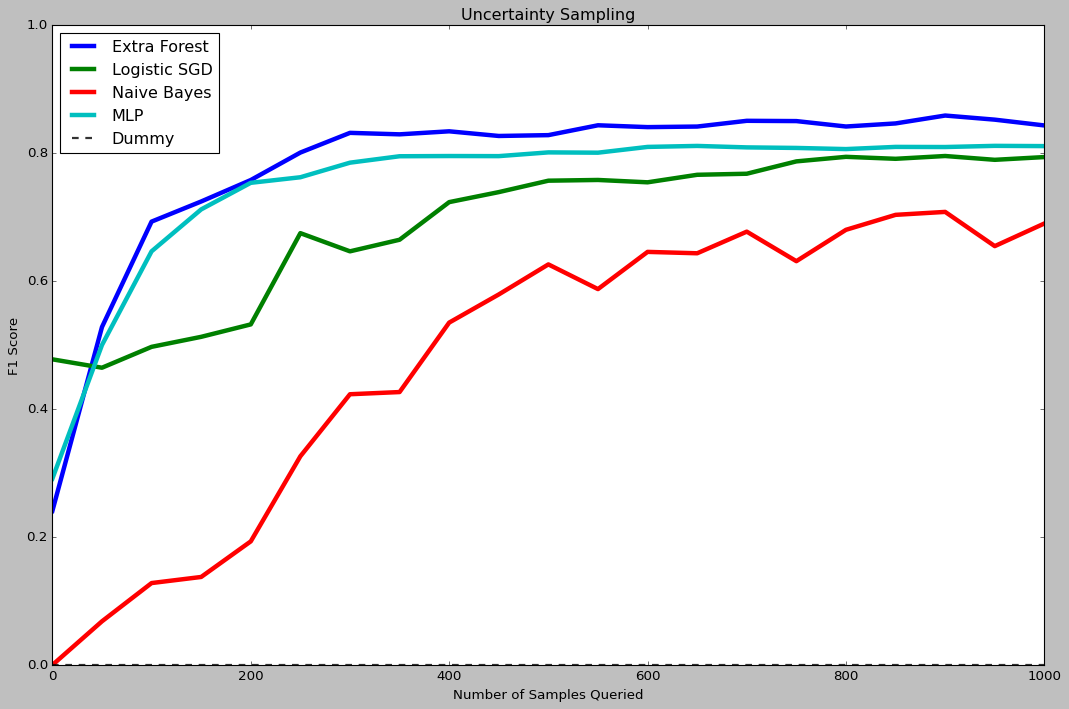

In [ ]:
V = manager.get_result("uncertainty",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Uncertainty Sampling")
plt.legend(loc='upper left')
plt.show()

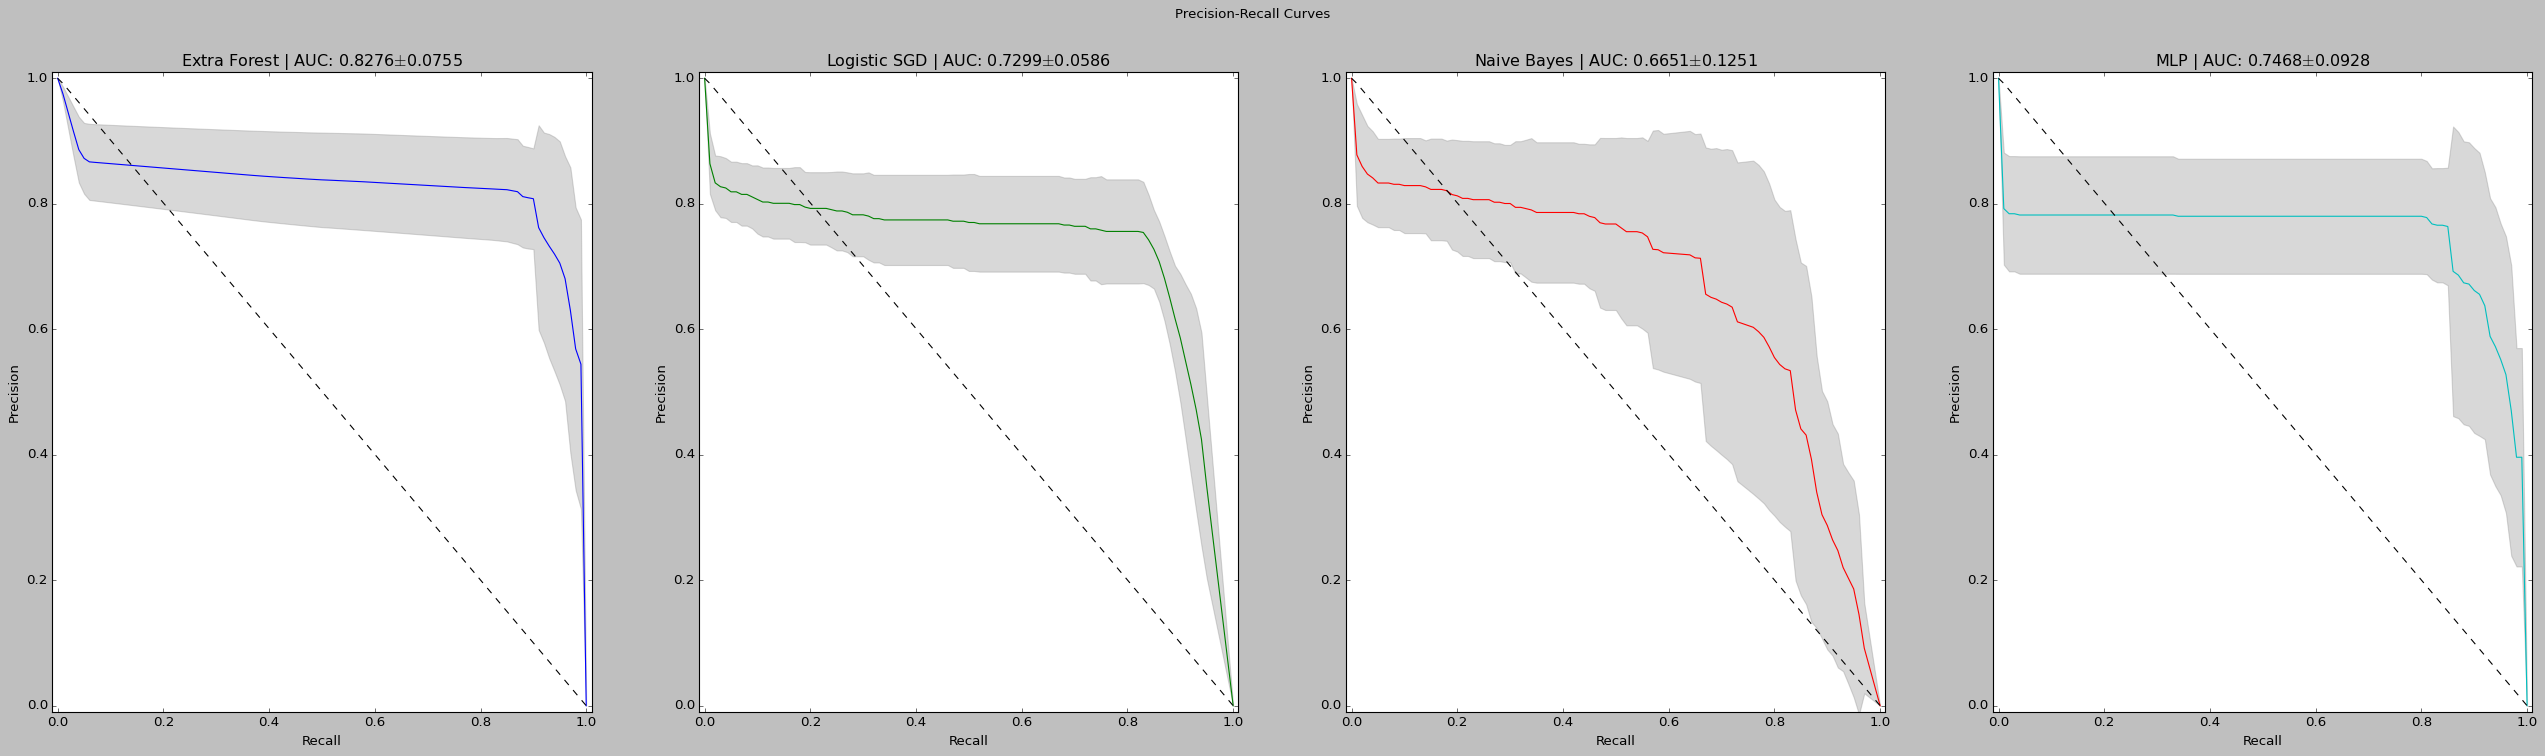

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='uncertainty', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Entropy Sampling

In [ ]:
if 'entropy' not in manager.experiments:
  manager.run_experiment_test('entropy')

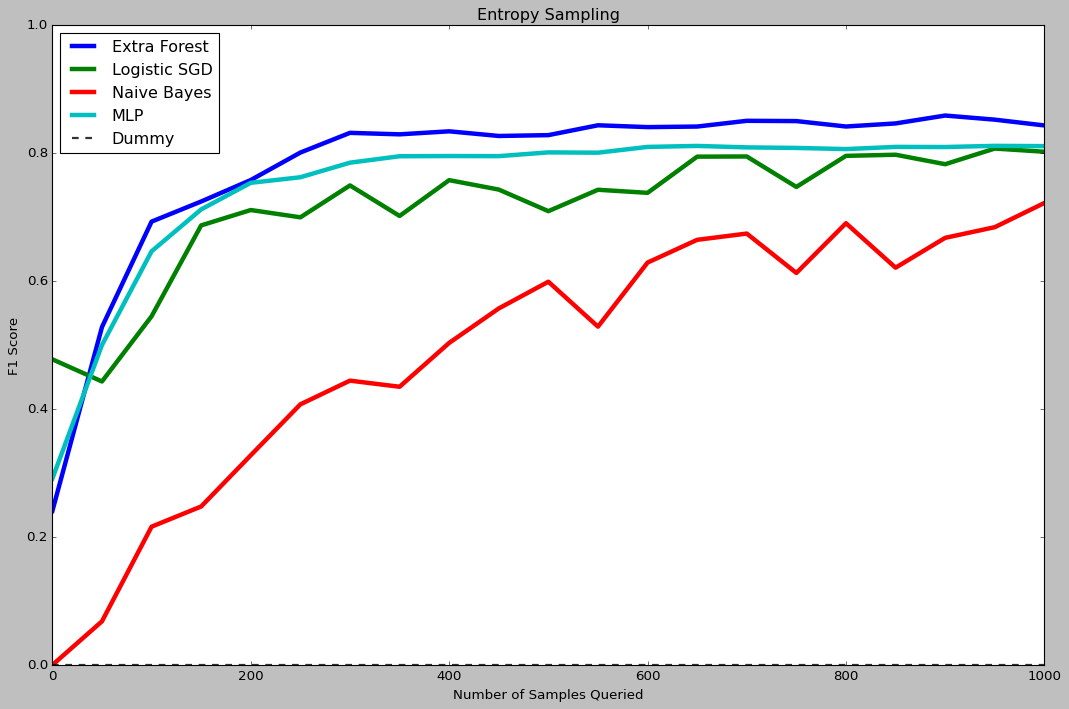

In [ ]:
V = manager.get_result("entropy",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Entropy Sampling")
plt.legend(loc='upper left')
plt.show()

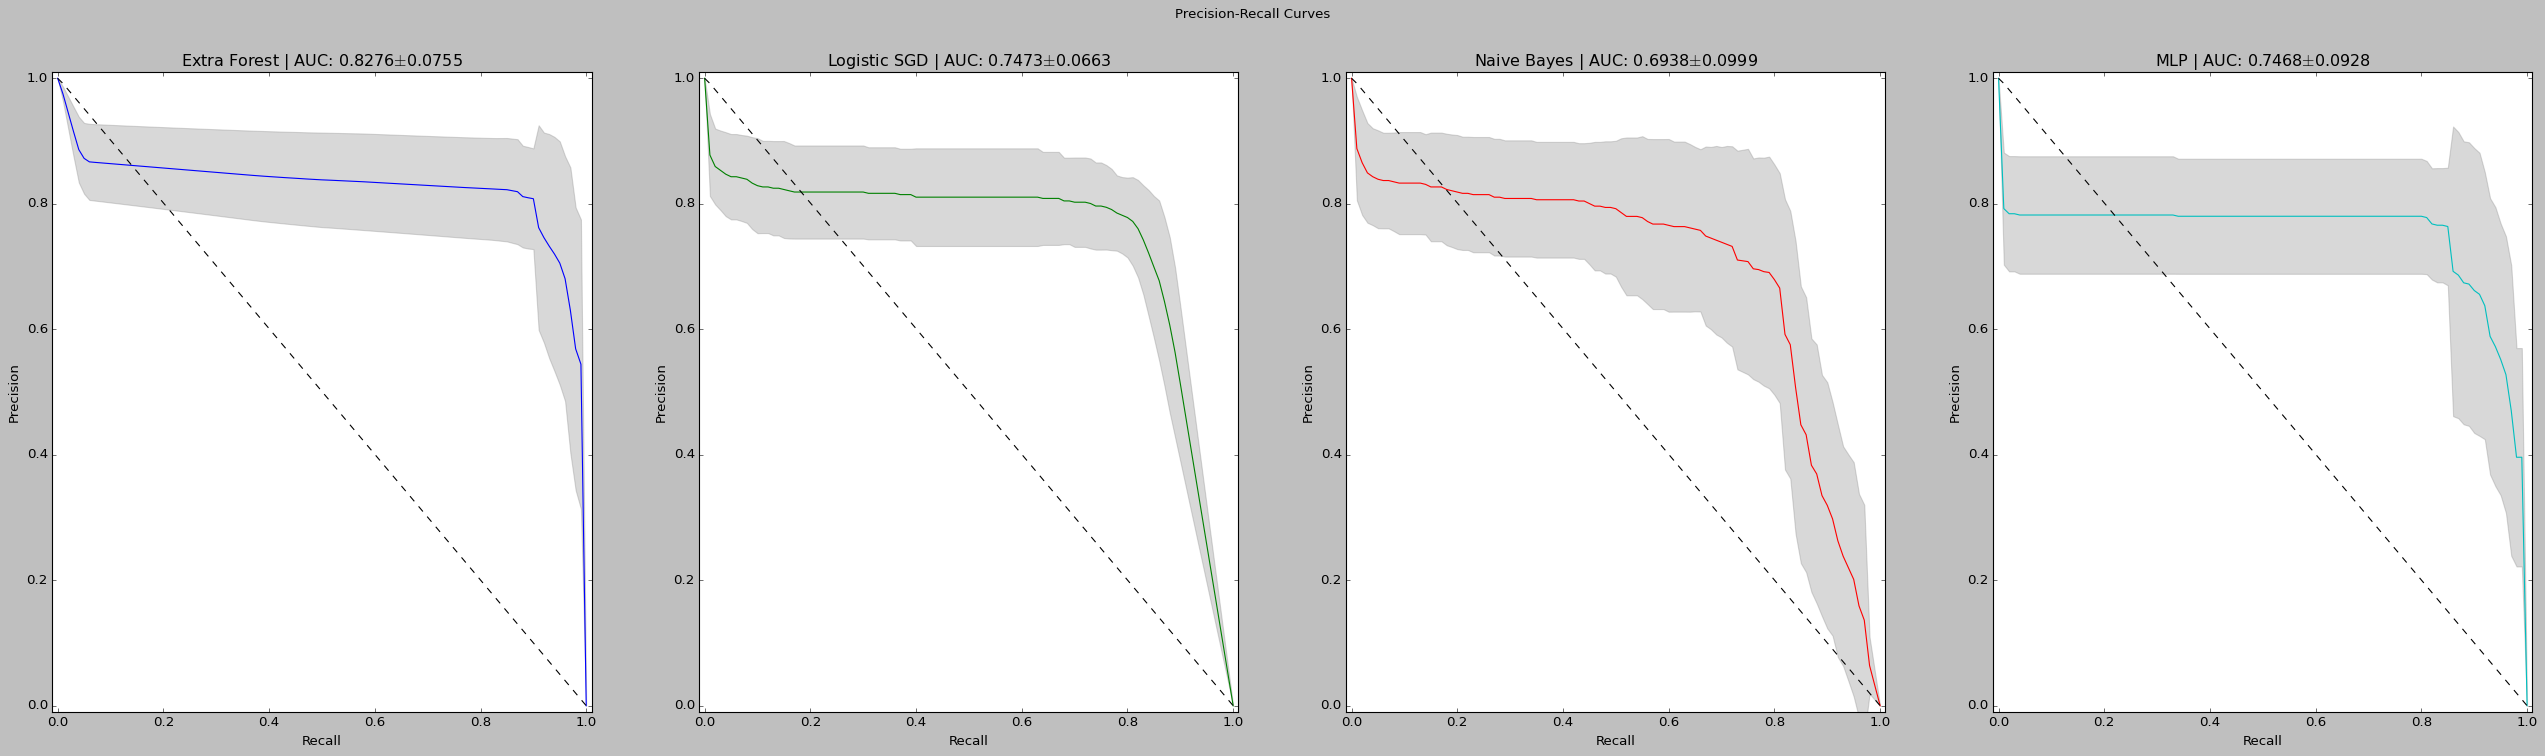

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='entropy', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Likely to be Fraud Sampling
AKA Fraudish Sampling

In [ ]:
if 'fraudish' not in manager.experiments:
  manager.run_experiment_test('fraudish')

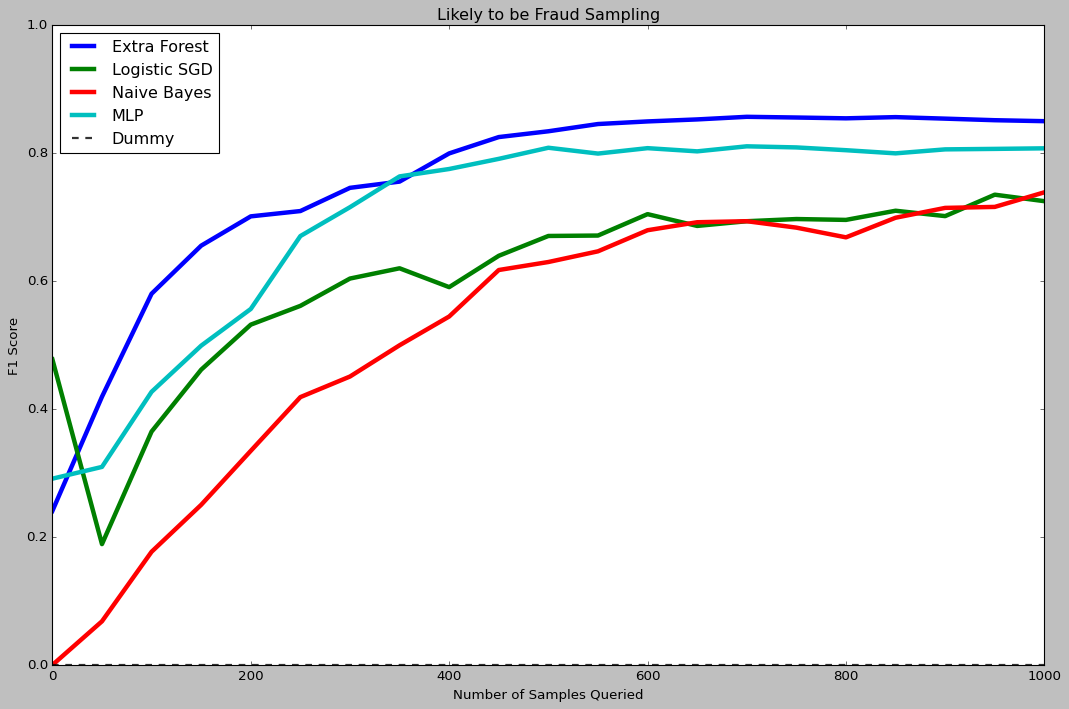

In [ ]:
V = manager.get_result("fraudish",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Likely to be Fraud Sampling")
plt.legend(loc='upper left')
plt.show()

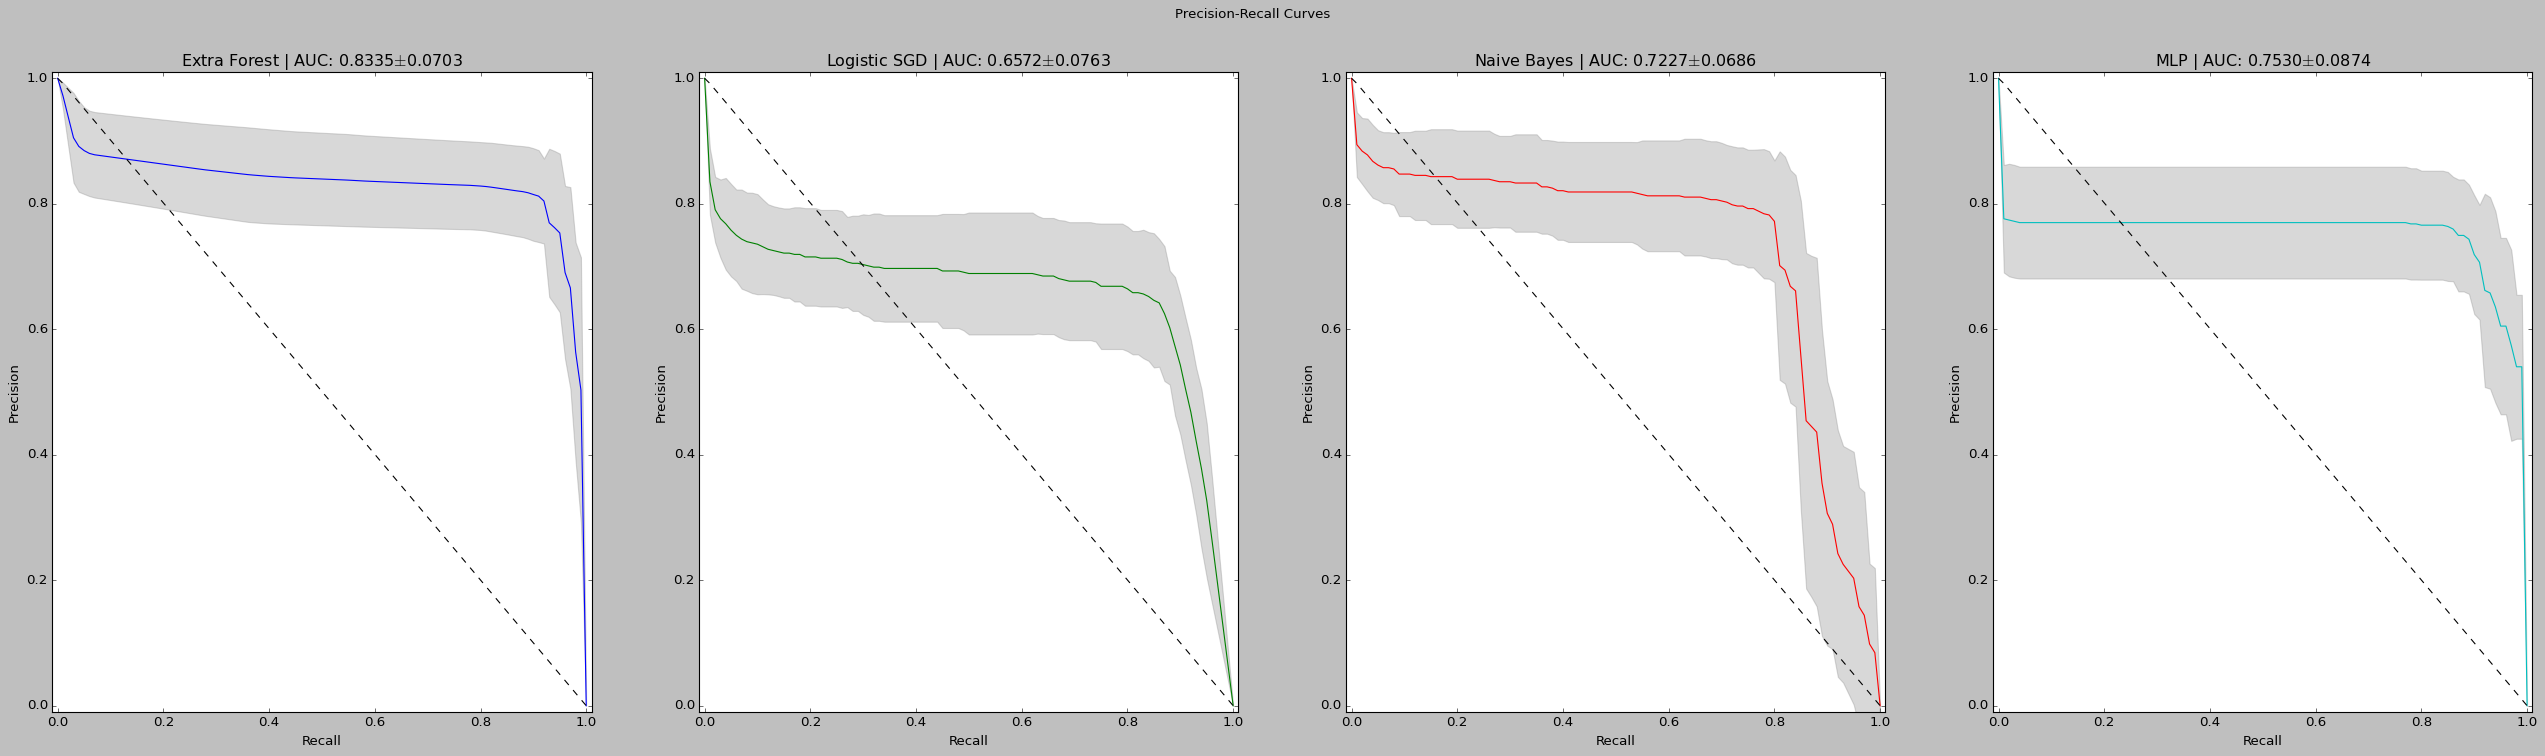

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='fraudish', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Per-Model View

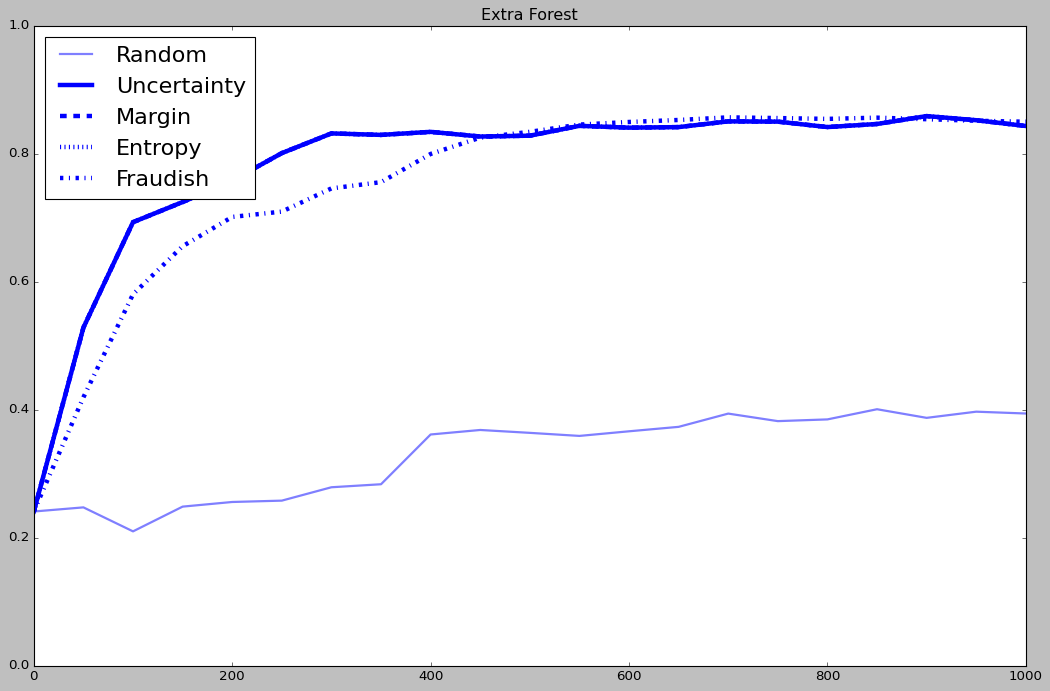

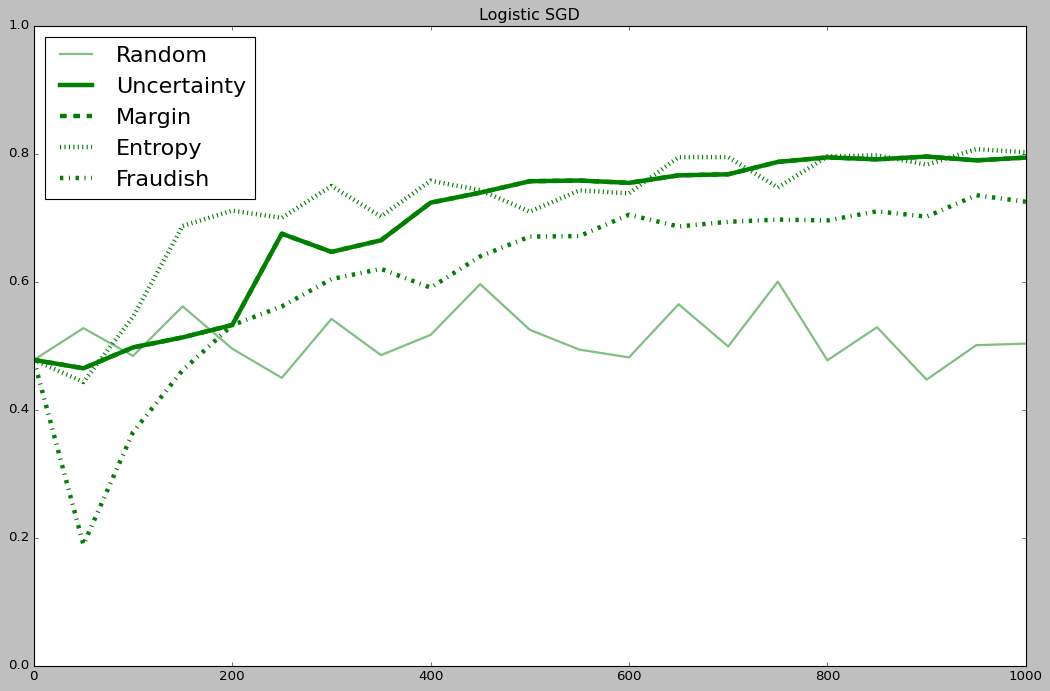

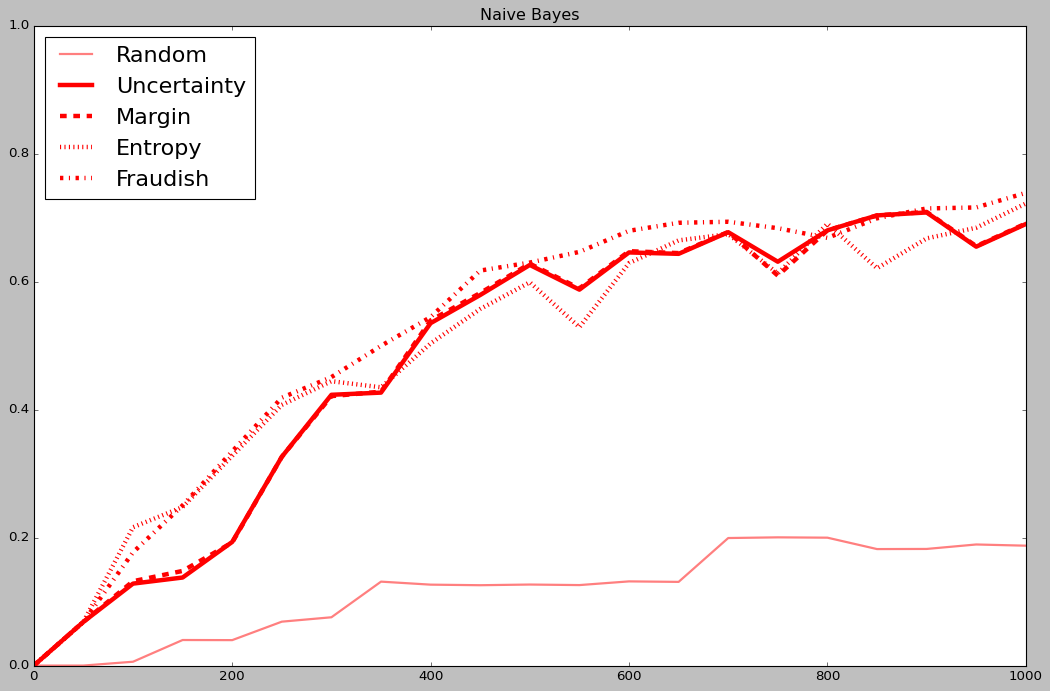

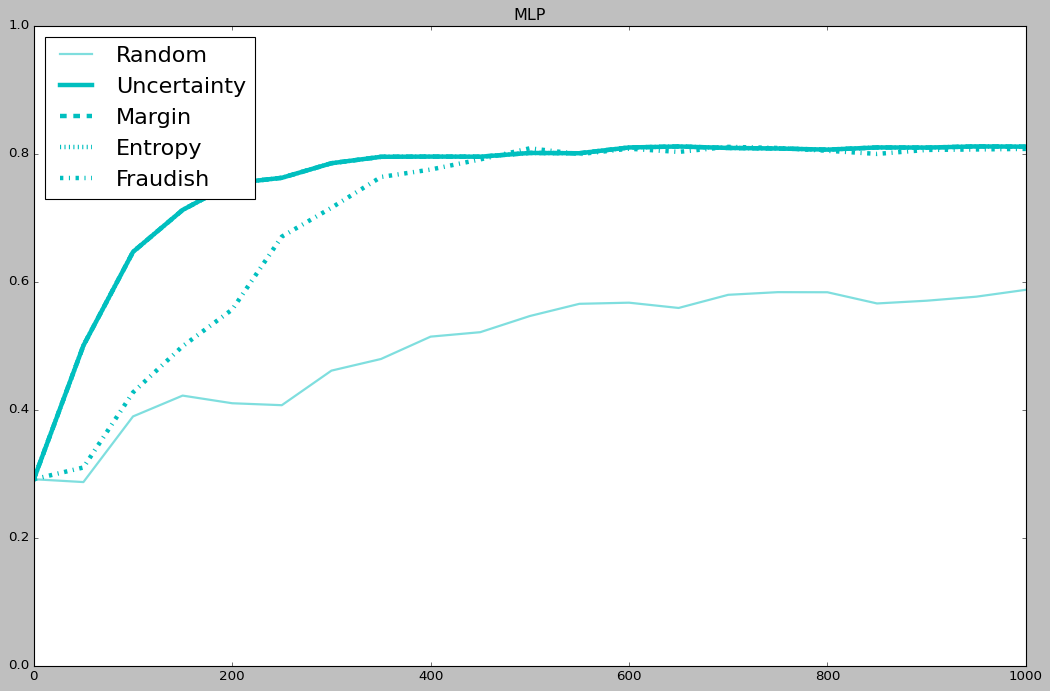

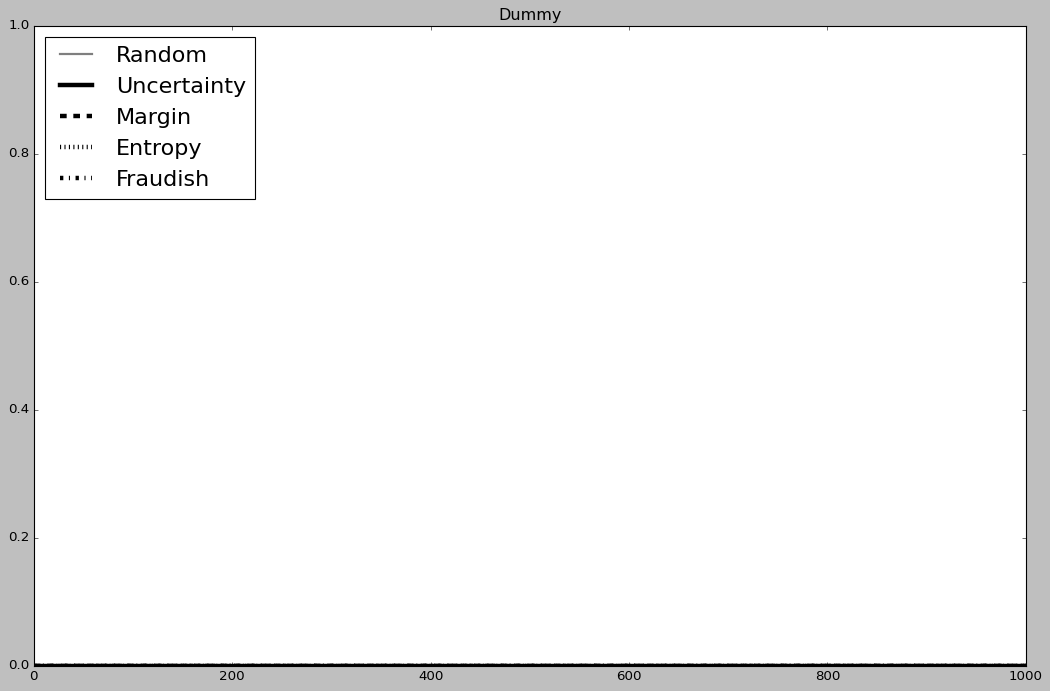

In [ ]:
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
for i,(c,n) in enumerate(zip(['C0','C1','C2','C3','k'],names)):
  plt.figure(num=1, figsize=(16, 10))
  for e, l, alpha in zip(samplers,['-','-','--',':','-.'],[0.5,1.0,1.0,1.0,1.0]):
    V = manager.get_result(e,metric='f1',).squeeze()
    plt.plot(q,V[i],color=c,linestyle=l, label=e.title(),linewidth=4*alpha, alpha=alpha)

  plt.ylim([0,1])
  plt.legend(prop={'size': 20}, loc='upper left')
  plt.title(n)
  plt.show()

In [ ]:
savefile = {'experiments':manager.experiments,'proba':manager.final_probas,'pred':manager.final_preds}
with open('ulb.pickle', 'wb') as handle:
    pk.dump(savefile, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
gc.collect()

27180

In [ ]:
from google.colab import files
files.download('ulb.pickle') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Dataset 2: IEEE

In [ ]:
os.environ['KAGGLE_USERNAME'] = "benjabby"
os.environ['KAGGLE_KEY'] = "a3e17634697e026f4396489db1115b71"

!mkdir ieee
!kaggle competitions download -c ieee-fraud-detection
!unzip train_identity.csv.zip -d ieee
!unzip train_transaction.csv.zip -d ieee
!rm sample_submission.csv.zip test_identity.csv.zip test_transaction.csv.zip train_identity.csv.zip train_transaction.csv.zip

mkdir: cannot create directory ‘ieee’: File exists
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 53.1MB/s]
 84% 49.0M/58.3M [00:02<00:00, 24.4MB/s]
100% 58.3M/58.3M [00:02<00:00, 27.5MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 105MB/s]
 79% 41.0M/52.2M [00:01<00:00, 18.5MB/s]
100% 52.2M/52.2M [00:01<00:00, 40.0MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 157MB/s]
Archive:  train_identity.csv.zip
replace ieee/train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train_transaction.csv.zip
replace ieee/train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace ieee/train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ieee_a = pd.read_csv("ieee/train_transaction.csv")
ieee_b = pd.read_csv("ieee/train_identity.csv")

`id_split` function courtesy of [David Cairuz](https://www.kaggle.com/davidcairuz)

In [ ]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [ ]:
ieee_b = id_split(ieee_b)

In [ ]:
ieee = ieee_a.merge(ieee_b, how='left', left_index=True, right_index=True)
del ieee_a, ieee_b

These useful features come from recursive feature elimination on this dataset. From [this kernel](https://www.kaggle.com/nroman/recursive-feature-elimination) by [nroman](https://www.kaggle.com/nroman)

In [ ]:
useful_features = ['isFraud','TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_32',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [ ]:
ieee = ieee.drop(columns=ieee.columns.difference(useful_features))
ieee = ieee.astype({'screen_width':float,'screen_height':float})

In [ ]:
ieee.shape

(590540, 285)

This dataset is too large, we can start by getting rid of all rows with too many missing values.


In [ ]:
ieee = ieee.dropna(thresh=140)

In [ ]:
ieee.shape

(196688, 285)

Impute the rest

In [ ]:
ieee.isna().sum().sum()

20274174

In [ ]:
for col in ieee:
    #get dtype for column
    dt = ieee[col].dtype 
    #check if it is a number
    if dt == int or dt == float:
        ieee[col].fillna(ieee[col].mean(), inplace=True)
    else:
        ieee[col].fillna(ieee[col].mode().iloc[0], inplace=True)

In [ ]:
ieee.isna().sum().sum()

0

It's now closer in size to dataset 1

In [ ]:
# ieee = ieee.sample(n=200000,random_state=SEED)

In [ ]:
y_df = ieee.isFraud
X_df = ieee.drop(columns=['isFraud'])
del ieee
gc.collect()

0

In [ ]:
X_df = pd.get_dummies(X_df)

In [ ]:
X_df.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V3,V4,V5,V6,V7,...,browser_id_31_waterfox,version_id_31_10.0,version_id_31_11.0,version_id_31_13.0,version_id_31_14.0,version_id_31_15.0,version_id_31_16.0,version_id_31_17.0,version_id_31_43.0,version_id_31_46.0,version_id_31_47.0,version_id_31_48.0,version_id_31_49.0,version_id_31_50.0,version_id_31_51.0,version_id_31_52.0,version_id_31_53.0,version_id_31_54.0,version_id_31_55.0,version_id_31_56.0,version_id_31_57.0,version_id_31_58.0,version_id_31_59.0,version_id_31_60.0,version_id_31_61.0,version_id_31_62.0,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_66.0,version_id_31_67.0,version_id_31_69.0,version_id_31_7.0,version_id_31_9.0,version_id_31_browser,version_id_31_generic,version_id_31_mobile,version_id_31_safari,version_id_31_search,version_id_31_webview
1,29.0,2755,404.0,150.0,102.0,325.0,87.0,125.142167,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,146.823882,30.818444,0.00000,42.833891,70.712218,146.779621,0.560931,0.000000,120.532013,53.237846,17.895793,57.672703,0.000000,1.052143,0.867076,0.89995,1.029221,1.054366,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,146.823882,30.818444,0.00000,42.833891,70.712218,146.779621,0.560931,0.000000,315.000000,53.237846,17.895793,57.672703,315.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50.0,4497,514.0,150.0,102.0,420.0,87.0,125.142167,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,146.823882,30.818444,99.54231,42.833891,70.712218,146.779621,0.560931,72.509718,120.532013,53.237846,17.895793,57.672703,105.324338,1.052143,0.867076,0.89995,1.029221,1.054366,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,146.823882,30.818444,0.00000,42.833891,70.712218,146.779621,0.560931,0.000000,0.000000,53.237846,17.895793,57.672703,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,422.5,12695,490.0,150.0,226.0,325.0,87.0,125.142167,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,146.823882,30.818444,0.00000,42.833891,70.712218,146.779621,0.560931,0.000000,120.532013,53.237846,17.895793,57.672703,0.000000,1.052143,0.867076,0.89995,1.029221,1.054366,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Still hightly imbalanced, but not as much so as dataset 1

In [ ]:
y_df.value_counts()

0    184605
1     12083
Name: isFraud, dtype: int64

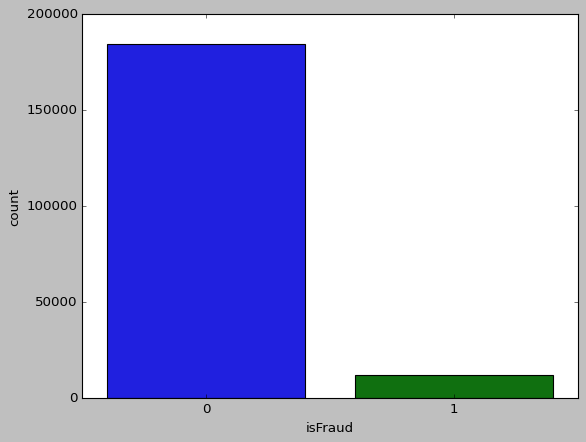

In [ ]:
sns.countplot(x=y_df)

### Experimental Setup

In [ ]:
X = X_df.values
y = y_df.values
del X_df, y_df

In [ ]:
manager = ExperimentManager(X,y,'ieee',scalable_cols='all',n_pca=50)
samplers = ['random','uncertainty','entropy','fraudish']

#### Random Sampling

In [ ]:
if 'random' not in manager.experiments:
  manager.run_experiment_test('random')

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


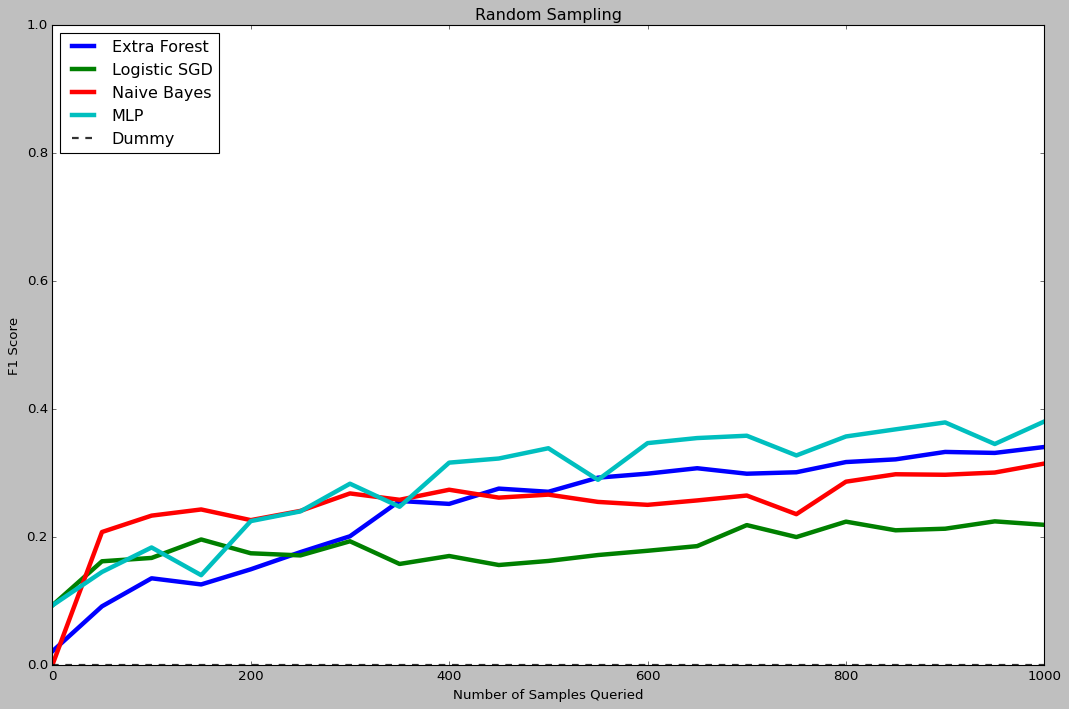

In [ ]:
V = manager.get_result("random",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Random Sampling")
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


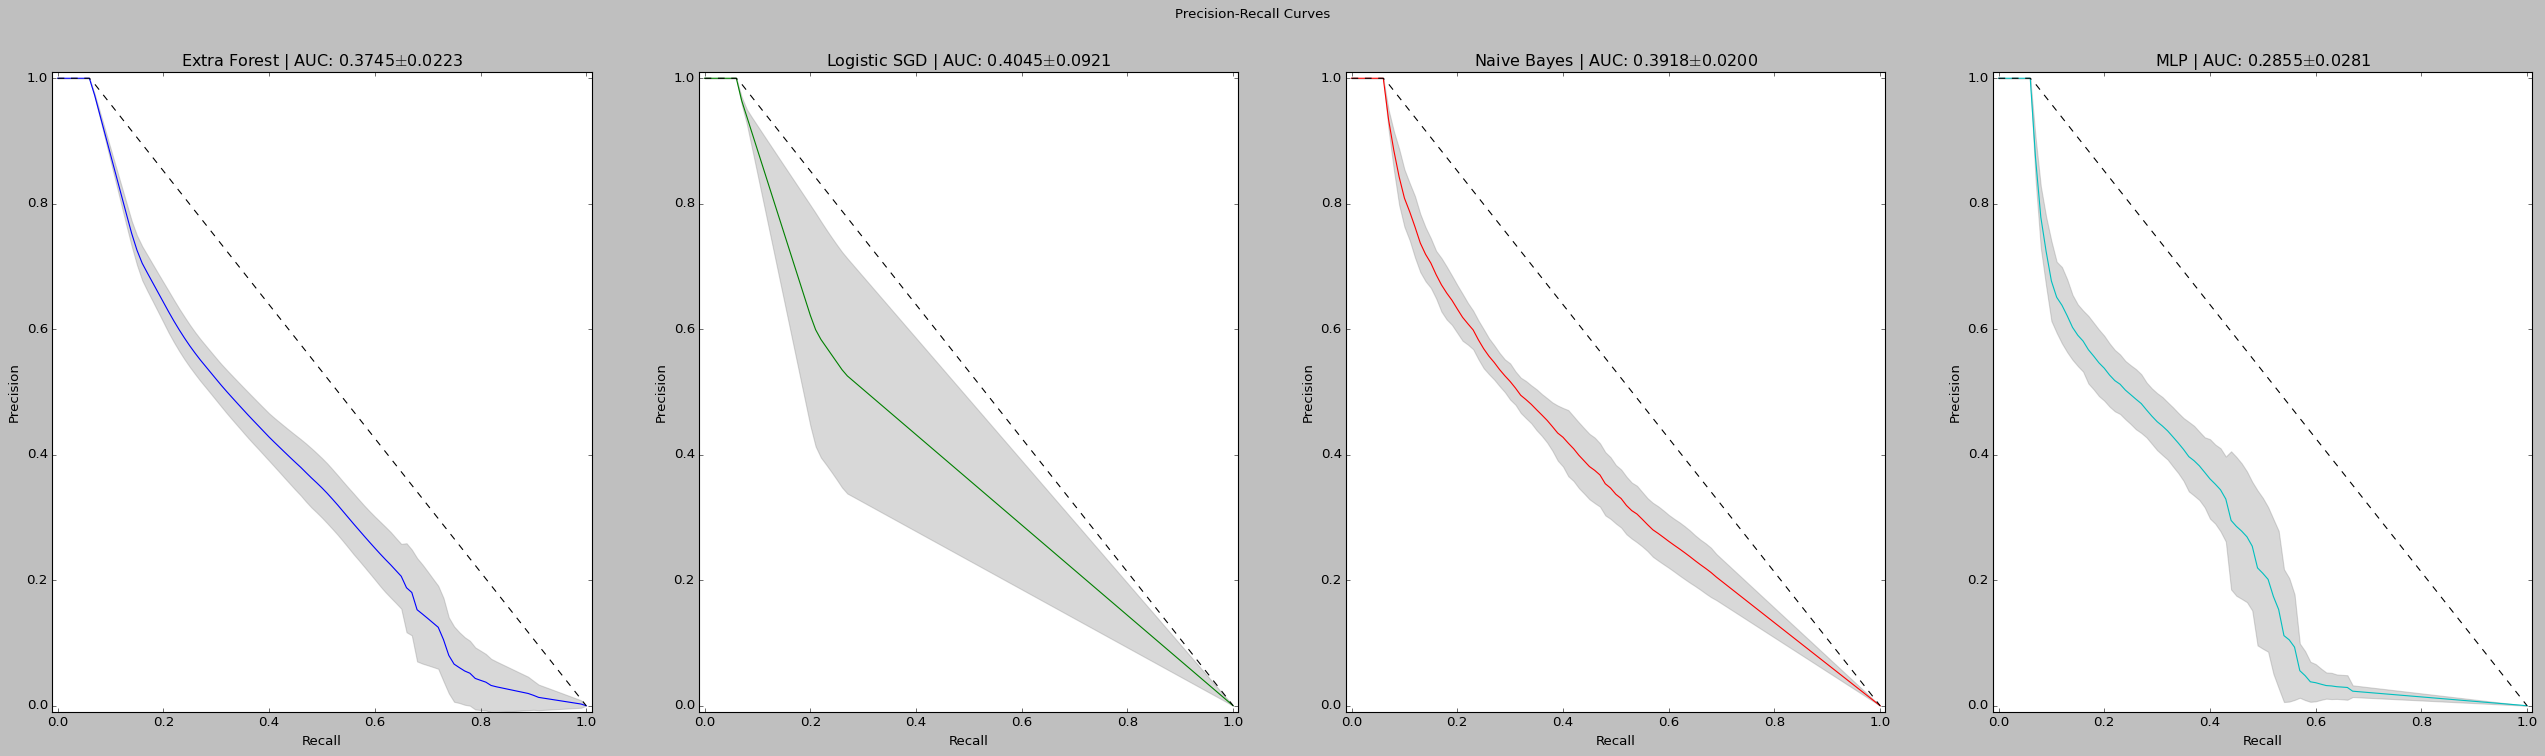

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='random', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Uncertainty Sampling

In [ ]:
if 'uncertainty' not in manager.experiments:
  manager.run_experiment_test('uncertainty')

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


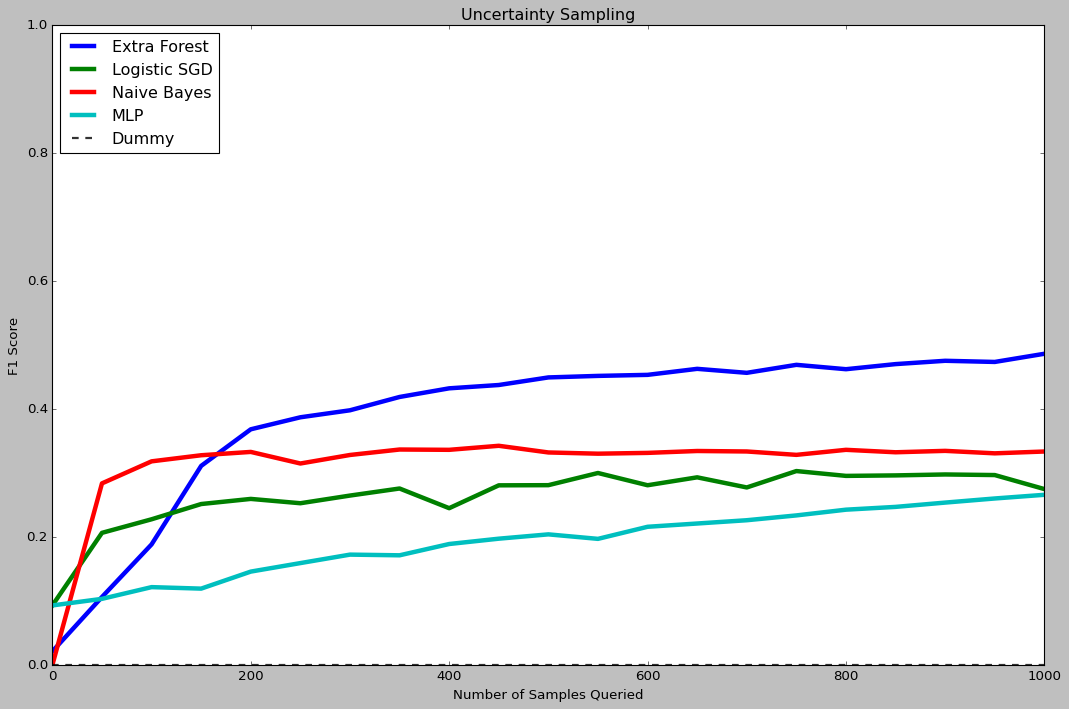

In [ ]:
V = manager.get_result("uncertainty",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Uncertainty Sampling")
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


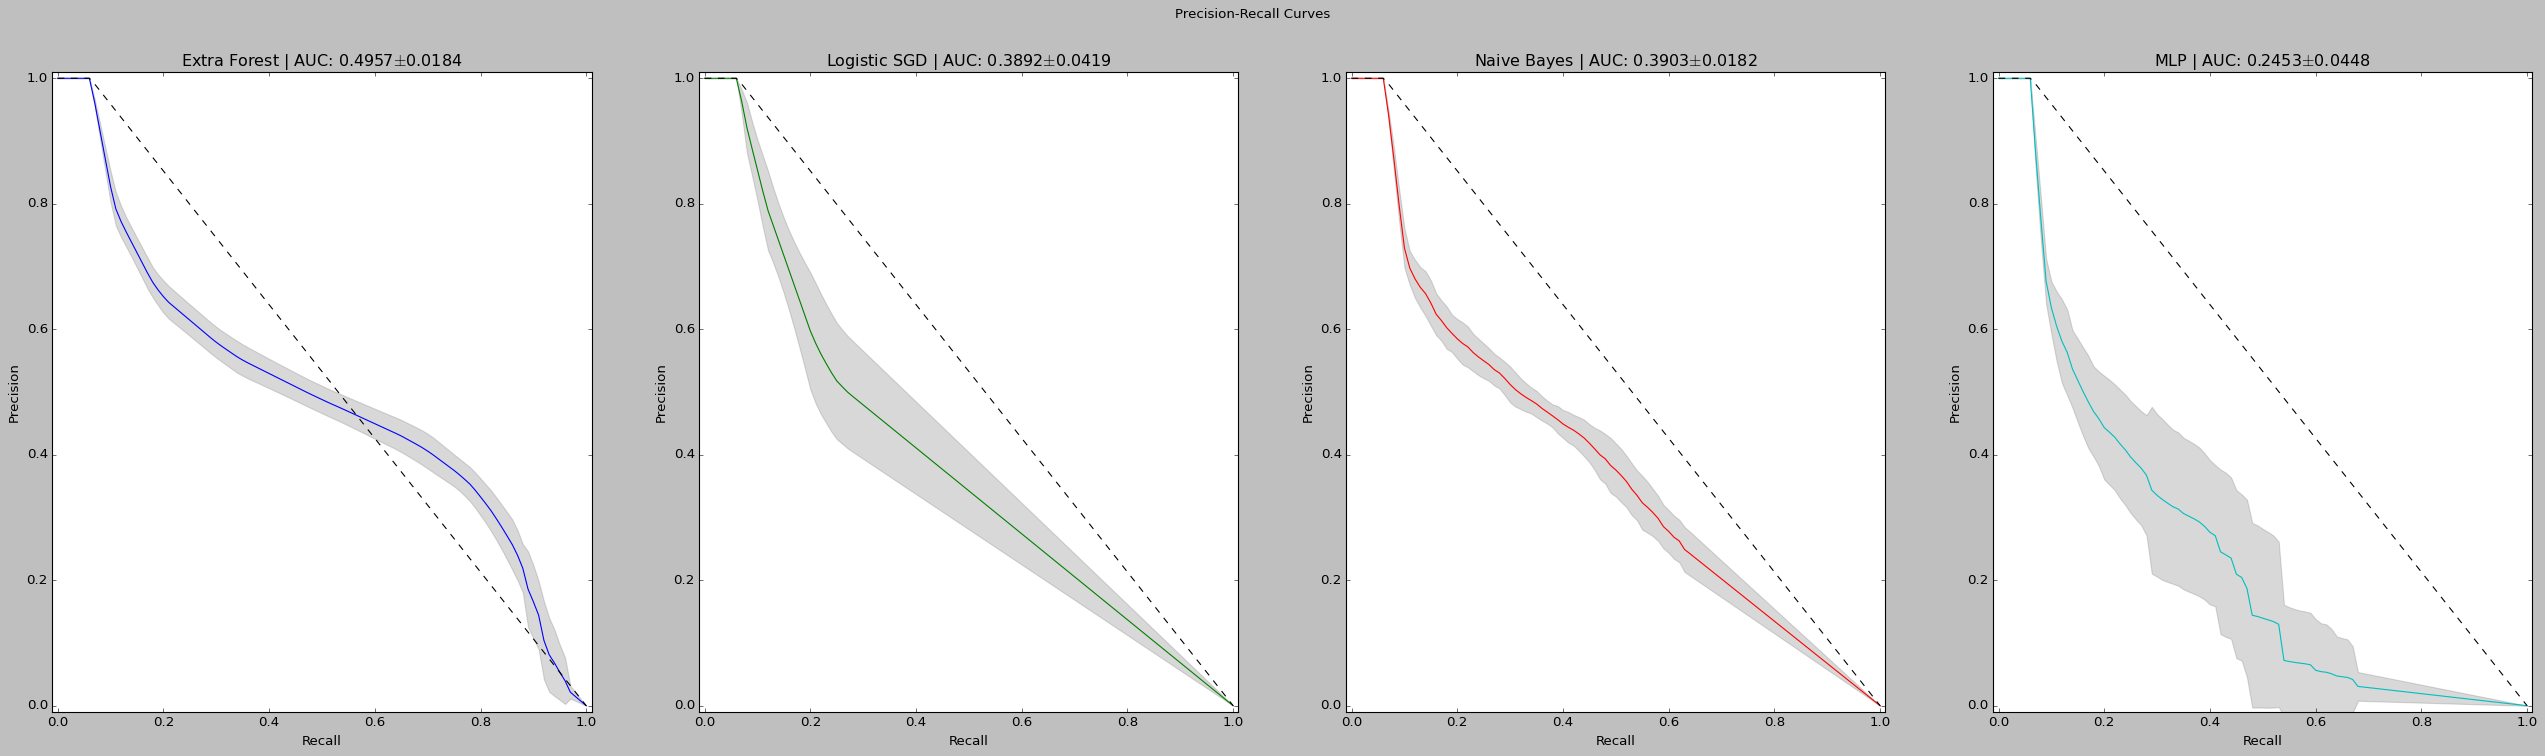

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='uncertainty', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Entropy Sampling

In [ ]:
if 'entropy' not in manager.experiments:
  manager.run_experiment_test('entropy')

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


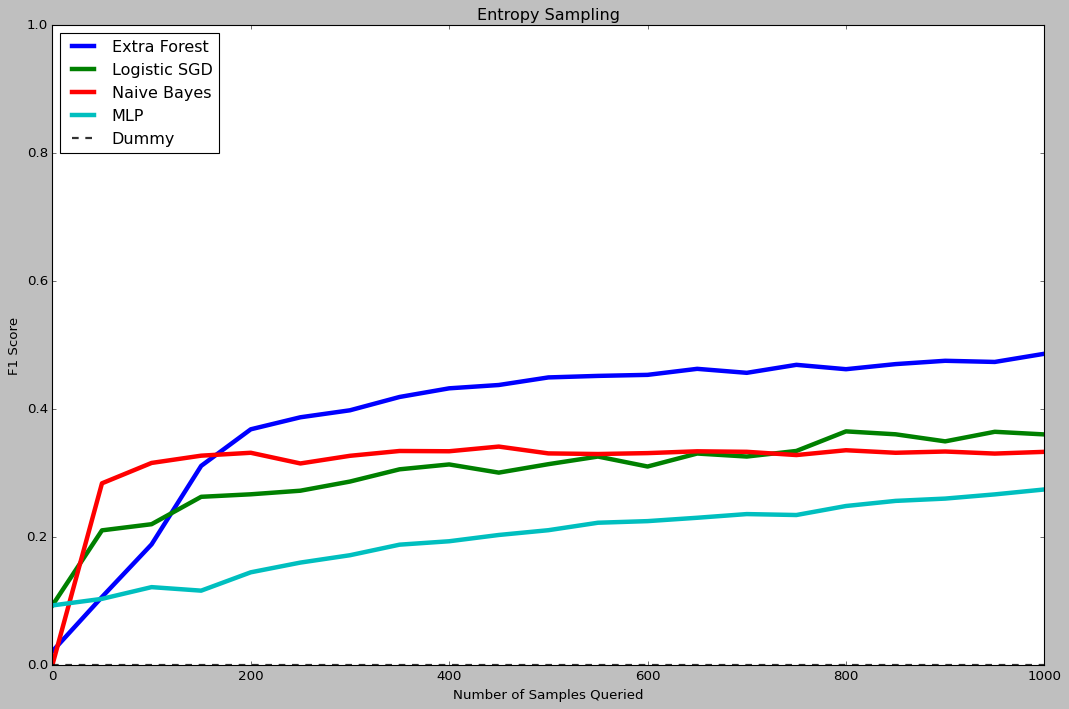

In [ ]:
V = manager.get_result("entropy",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Entropy Sampling")
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


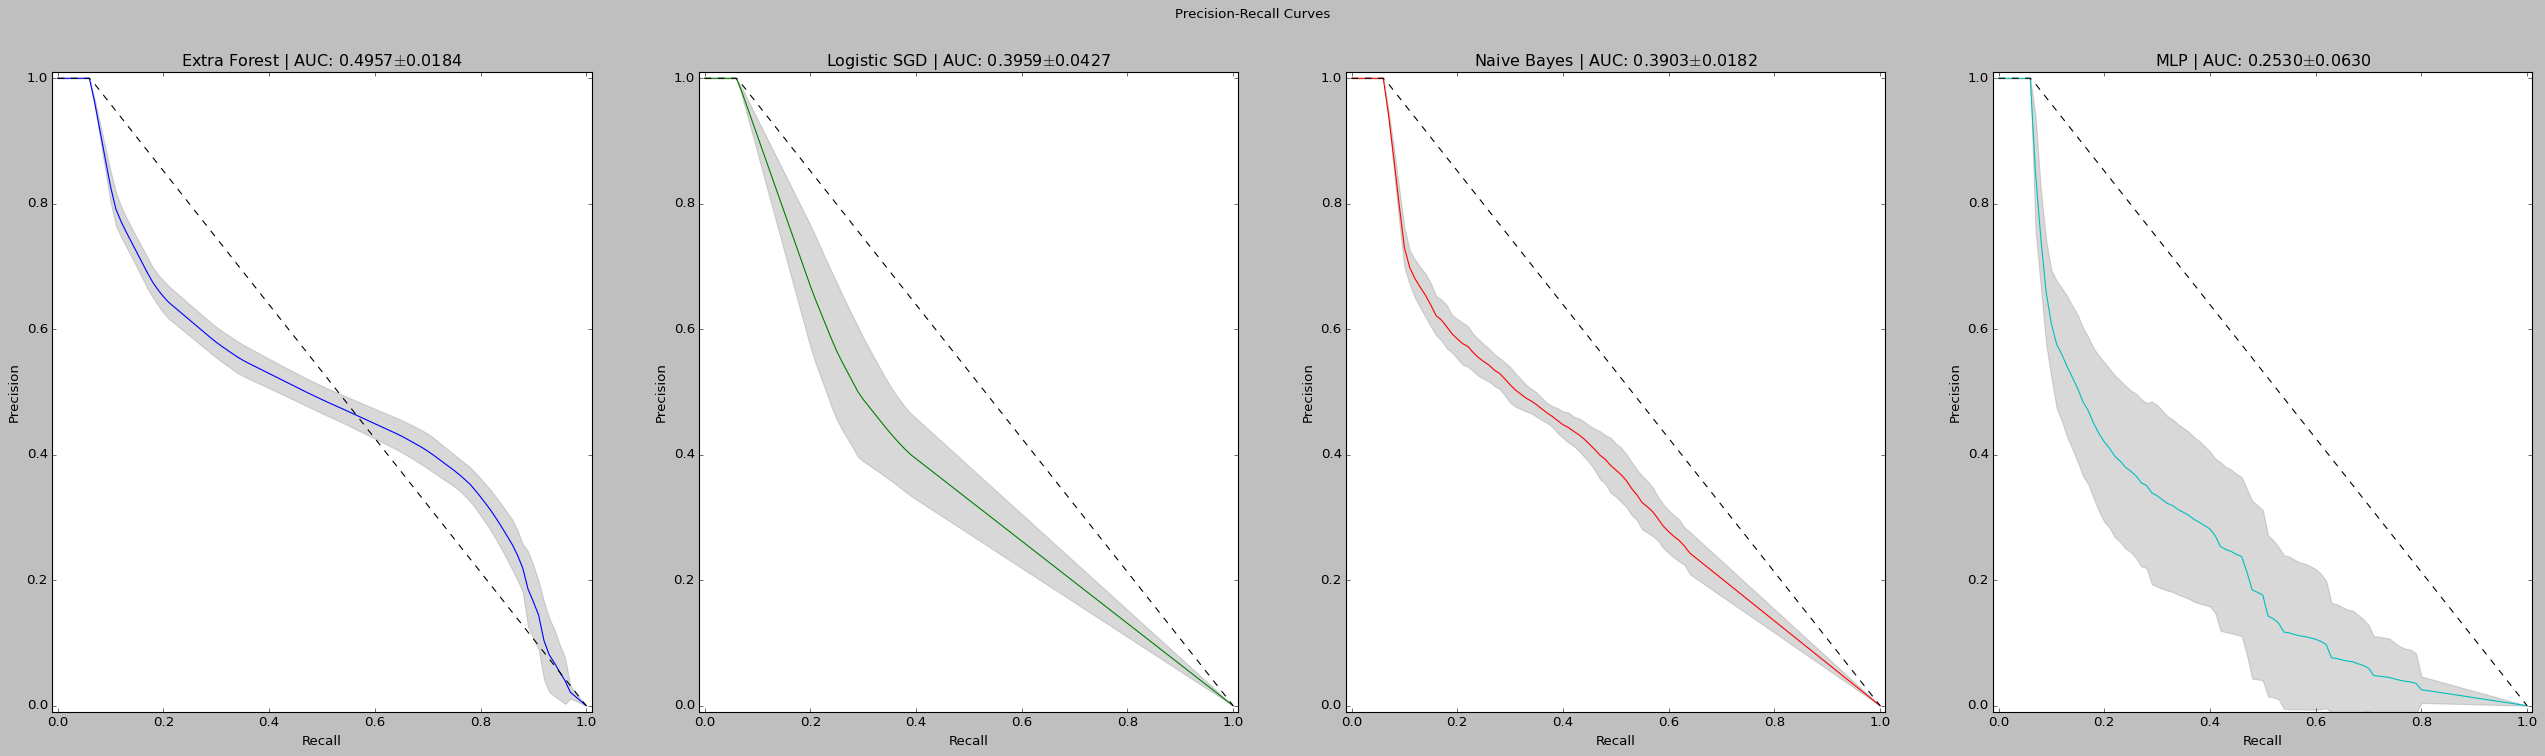

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='entropy', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Likely to be Fraud Sampling
AKA Fraudish Sampling

In [ ]:
if 'fraudish' not in manager.experiments:
  manager.run_experiment_test('fraudish')

NameError: ignored

In [ ]:
V = manager.get_result("fraudish",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
for i,n in enumerate(names):
  if "Dummy" in n:
    plt.plot(q,V[i],label=n,alpha=0.8, linewidth=2, linestyle='--', c='k')
  else:
    plt.plot(q,V[i],label=n, linewidth=4)
  
plt.ylim([0,1])
plt.xlabel("Number of Samples Queried")
plt.ylabel("F1 Score")
plt.title("Likely to be Fraud Sampling")
plt.legend(loc='upper left')
plt.show()

In [ ]:
p_r_curves, p_r_auc = manager.get_precision_recall_curves(experiment='fraudish', include_std=True, return_auc=True)
names = manager.base_model_names
x = np.linspace(0,1,101)
num = len(names)-1
fig, axes = plt.subplots(1,num,figsize=(10*num,10))
for curve, col, n, ax, a in zip(p_r_curves[:-1], ['C0','C1','C2','C3'], names, axes, p_r_auc[:-1]):
  mean, lower, upper = curve
  ax.plot(x, mean, col)
  ax.fill_between(x, lower, upper, color='grey', alpha=0.3)
  ax.plot(x, p_r_curves[-1][0],'k--')
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  ax.set_title("{n} | AUC: {auc:.4f}$\pm${std:.4f}".format(n=n, auc=a[0],std=a[1]))
  #ax.set_aspect('equal', 'datalim')

fig.suptitle("Precision-Recall Curves")
plt.show()

#### Per-Model View

In [ ]:
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
for i,(c,n) in enumerate(zip(['C0','C1','C2','C3','k'],names)):
  plt.figure(num=1, figsize=(16, 10))
  for e, l, alpha in zip(samplers,['-','-','--',':','-.'],[0.5,1.0,1.0,1.0,1.0]):
    V = manager.get_result(e,metric='f1',).squeeze()
    plt.plot(q,V[i],color=c,linestyle=l, label=e.title(),linewidth=4*alpha, alpha=alpha)

  plt.ylim([0,1])
  plt.legend(prop={'size': 20}, loc='upper left')
  plt.title(n)
  plt.show()

In [ ]:
savefile = {'experiments':manager.experiments,'proba':manager.final_probas,'pred':manager.final_preds}
with open('ieee.pickle', 'wb') as handle:
    pk.dump(savefile, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
gc.collect()

In [ ]:
from google.colab import files
files.download('ieee.pickle') 

# OLD


In [ ]:
# Generalized
class Oracle():
  def __init__(self, cost, accuracy, seed):
    self.rng = np.random.RandomState()
    self.seed = seed
    self.rng.seed(seed)
    self.cost = cost
    self.accuracy = accuracy
  #   self.already_labeled = []
  
  # def check_labeled(self, index):
  #   return index in self.already_labeled
  
  def reset_rng(self):
    self.rng.seed(self.seed)
  
  def get_answer(self, ground_truth):
    return ground_truth if self.rng.uniform() <= self.accuracy else 1-ground_truth

class ExperimentManager():
  def __init__(self, X, y, dataset_name, cols_to_scale=None, base_models=None, initial_pool=10, default_queries=100, cv_folds=10, seed=SEED):
    self.name = dataset_name
    self.X = X
    self.y = y
    self.seed = seed
    self.rng = np.random.RandomState()
    self.__reset_rng()

    self.oracles = [Oracle(0.1,1,self.rng.randint(np.iinfo(np.uint32).max,dtype=np.uint32)),Oracle(0.01,0.9,self.rng.randint(np.iinfo(np.uint32).max,dtype=np.uint32))]

    self.__reset_rng()

    self.budget = 1.0

    '''
    List containing tuples of cv-split indices of the format (train set labeled, train set unlabeled, test set)
    '''
    self.splits = []

    # if initial_pool <= 0.5:
    #   big_fold = False
    #   pool_fold = round(1/initial_pool)
    # else:
    #   big_fold = True
    #   pool_fold = round(1/(1.0-initial_pool))

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.seed)
    for train_i, test_i in cv.split(self.X, self.y):
      # Q = train_i[self.y[train_i]==1]
      # q = train_i[self.y[train_i]==0]
      # train_l_i = np.concatenate([Q[self.rng.randint(Q.shape[0],size=1)],q[self.rng.randint(Q.shape[0],size=initial_pool-1)]])
      # train_p_i = train_i
      train_l_i, train_p_i = sk.model_selection.train_test_split(train_i, train_size=initial_pool)#, stratify=self.y[train_i])
      self.splits.append((train_l_i,train_p_i,test_i))
      # A roundabout way to get a fixed stratified subset for each fold (representing the initial pool of labeled data) is to do another StratifiedKFold on the folds training set
      
      # big, small = next(StratifiedKFold(n_splits=pool_fold, shuffle=True,random_state=self.seed).split(X[train_i],y[train_i]))
      # #                     (train set labeled, train set unlabeled,  test set)
      # if big_fold:
      #   self.splits.append( (train_i[big],      train_i[small],       test_i))
      # else:
      #   self.splits.append( (train_i[small],    train_i[big],         test_i))

    # Do not train.
    self.base_models = [DecisionTreeClassifier(), ExtraTreesClassifier(n_estimators=50), KNeighborsClassifier(n_jobs=-1), SVC(cache_size=500, probability=True), SGDClassifier(loss='log')] if base_models is None else base_models.values()
    self.base_model_names = ['Decision Tree', 'Extra Forest', 'KNN', 'SVM', 'Logistic SGD'] if base_models is None else base_models.keys()
    # self.base_models = [ExtraTreesClassifier(n_estimators=10),LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')] if base_models is None else base_models.values()
    # self.base_model_names = ['Extra Forest', 'LDA'] if base_models is None else base_models.keys()

    self.M = len(self.base_models)
    self.F = cv_folds
    self.default_queries = default_queries

    '''
    experiments format: {'Experiment1':results1, 'Experiment2':results2, 'ExperimentN':resultsN}

    results format: numpy array of shape (M, F, K, V) where
    M is the number of models the experiment manager is testing, corresponding to the order of self.base_models & self.base_model_names - Per experiment manager
    F is the number of cross validation folds tested                                                                                    - Per experiment manager
    K is the number of active learning queries performed (e.g how many new samples are labeled) + 1 for the initial pool query.         - Per experiment
    V is 5, containing [spent budget, TN, FP, FN, TP]                                                                                   - Fixed

    Thus a value at results1[m,f,k] represents the confusion matrix values for for Experiment1 on model m, using fold f, after k queries.
    '''
    self.experiments = {}

  def __reset_rng(self):
    self.rng.seed(self.seed)

  '''
  equivalent to initial_pool=1 
  '''
  def run_full_set_control(self, verbose=False):
    loading_bar = display(progress(0, self.M*self.F), display_id=True)
    results = np.zeros((self.M,self.F,1,4))
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold}:".format(name=name,fold=f), end=" ")

        train_i, test_i = np.concatenate(split[:2]), split[2]

        X_train, X_test = self.X[train_i], self.X[test_i]
        y_train, y_test = self.y[train_i], self.y[test_i]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed) 

        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        results[m,f,0] = confusion_matrix(y_test, pred).ravel()

        loading_bar.update(progress(m*self.F+f+1,self.M*self.F))
        if verbose:
          print("DONE")

        f += 1
      m +=1
    self.experiments['Control - All Data'] = results

  def run_experiment_simple(self, title, query_method, oracle_method, random=False, verbose=False):
    # K = self.default_queries if queries is None or queries<0 else queries
    # K += 1

    loading_bar = display(progress(0, self.M*self.F), display_id=True)
    self.budget = 1.0
    
    #results = np.zeros((self.M,self.F,K,5))
    results = []
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      folds = []
      for split in self.splits:
        self.__reset_rng()

        values = []

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_train, X_pool, X_test = self.X[split[0]], self.X[split[1]], self.X[split[2]]
        y_train, y_pool, y_test = self.y[split[0]], self.y[split[1]], self.y[split[2]]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)

        learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)

        c = np.zeros(5)
        c[0] = 0
        c[1:] = confusion_matrix(y_test, pred).ravel()
        values.append(c)

        #results[m,f,0,0] = 0
        #results[m,f,0,1:] = confusion_matrix(y_test, pred).ravel()
        
        if verbose:
          print("Unqueried", end=" | ")

        while self.budget > 0:
          if random:
            query_index = self.rng.randint(X_pool.shape[0]+1)
          else:
            query_index, _ = learner.query(X_pool)

          X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )

          oracle = oracle_method(self.oracles, self.budget)
          oracle_answer = oracle.get_answer(y)
          learner.teach(X=X, y=oracle_answer)
          self.budget -= oracle.cost

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)

          c = np.zeros(5)
          c[0] = 1-self.budget
          c[1:] = confusion_matrix(y_test, pred).ravel()
          values.append(c)
          #results[m,f,k, 0] = 1-self.budget
          #results[m,f,k, 1:] = confusion_matrix(y_test, pred).ravel()

          #loading_bar.update(progress(m*self.F*K+f*K+k+1,self.M*self.F*K))
          # if verbose:
          #   print(k, end=", ")
          
        loading_bar.update(progress(m*self.F+f+1,self.M*self.F))
          
        if verbose:
          print("DONE")

        f += 1
        folds.append(np.array(values))
        self.budget = 1.0

      results.append(folds)
      m +=1
    
    self.experiments[title] = results
    

  def run_experiment_advanced(self, title, integrated_method, verbose=False):
    pass
  
  def run_experiment_test(self, title, queries=None, verbose=False, random=False):
    '''
    '''
    K = self.default_queries if queries is None or queries<0 else queries
    K += 1

    loading_bar = display(progress(0, self.M*self.F*K), display_id=True)
    
    results = np.zeros((self.M,self.F,K,4))
    m = 0
    for name, base in zip(self.base_model_names, self.base_models):
      f = 0
      for split in self.splits:
        self.__reset_rng()

        if verbose:
          print("{name} fold {fold} |".format(name=name,fold=f), end=" ")

        X_train, X_pool, X_test = self.X[split[0]], self.X[split[1]], self.X[split[2]]
        y_train, y_pool, y_test = self.y[split[0]], self.y[split[1]], self.y[split[2]]

        clf = sk.base.clone(base)
        if 'random_state' in clf.get_params().keys():
          clf.set_params(random_state=self.seed)

        learner = al.ActiveLearner(estimator=clf, X_training=X_train, y_training=y_train)

        pred = learner.predict(X_test)
        results[m,f,0] = confusion_matrix(y_test, pred).ravel()
        loading_bar.update(progress(m*self.F*K+f*K+1,self.M*self.F*K))
        if verbose:
          print("Unqueried", end=" | ")

        for k in range(1,K):
          if random:
            query_index = self.rng.randint(X_pool.shape[0]+1)
          else:
            query_index, _ = learner.query(X_pool)

          X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
          learner.teach(X=X, y=y)

          X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

          pred = learner.predict(X_test)
          results[m,f,k] = confusion_matrix(y_test, pred).ravel()

          loading_bar.update(progress(m*self.F*K+f*K+k+1,self.M*self.F*K))
          if verbose:
            print(k, end=", ")
          
        if verbose:
          print("DONE")

        f += 1
      m +=1
    
    self.experiments[title] = results


  # TODO. Finish properly
  def get_result(self, experiment=None, model='all', metric=None, queries='all', fold=None, budget_step=0.01):
    if experiment is None: return

    result = self.experiments[experiment]
    dim_names = np.array(['Experiment','Model','Fold','Kth-Query','Confusion Values'])

    if queries=='all':
      num = int(np.ceil(1/budget_step)+1)
      x = np.linspace(0,1,num=num)
      i_result = np.zeros((self.M,self.F,num,4))
      m=0
      for M in result:
        f=0
        for F in M:
          q = np.array(F)

          i_result[m,f,:,0] = np.interp(x,q[:,0],q[:,1])
          i_result[m,f,:,1] = np.interp(x,q[:,0],q[:,2])
          i_result[m,f,:,2] = np.interp(x,q[:,0],q[:,3])
          i_result[m,f,:,3] = np.interp(x,q[:,0],q[:,4])

          f+=1
        m+=1

      result = i_result

      # #result_dict
      if metric is not None:
        TN, FP, FN, TP = result[...,0], result[...,1], result[...,2], result[...,3]
        if metric=='tn': result = TN
        elif metric=='fp': result = FP
        elif metric=='fn': result = FN
        elif metric=='tp': result = TP
        elif metric=='recall': result = TP/(TP+FN)
        elif metric=='precision': retult = TP/(TP+FP)
        elif metric=='mcc': result = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        elif metric=='f1': result = TP/(TP+0.5*(FP+FN))

        result = np.expand_dims(result,-1)

      if model is None or model=='avg':
        result = np.mean(result, axis=0, keepdims=True)
      if fold is None or fold=='avg':
        result = np.mean(result, axis=1, keepdims=True)
      if queries is None or queries=='last':
        result = result[:,:,-1,np.newaxis,:]
      
      return x, result

## Dataset 1: Mushrooms

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

--2020-08-28 01:54:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [application/x-httpd-php]
Saving to: ‘agaricus-lepiota.data’

agaricus-lepiota.da 100%[===================>] 364.95K  1.34MB/s    in 0.3s    

2020-08-28 01:54:47 (1.34 MB/s) - ‘agaricus-lepiota.data’ saved [373704/373704]



In [ ]:
shrooms = pd.read_csv("agaricus-lepiota.data",names=['Edible','CapShape','CapSurface','CapColor','Bruises','Odor','GillAttachnent','GillSpacing','GillSize','GillColor','StalkShape','StalkRoot','StalkSurfaceAboveRing','StalkSurfaceBelowRing','StalkColorAboveRing','StalkColorBelowRing','VeilType','VeilColor','RingNumber','RingType','SporePrintColor','Population','Habitat'])

In [ ]:
shrooms.head()

,Edible,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachnent,GillSpacing,GillSize,GillColor,StalkShape,StalkRoot,StalkSurfaceAboveRing,StalkSurfaceBelowRing,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


2480 missing values, all for StalkRoot

In [ ]:
(shrooms=='?').sum()

Edible                      0
CapShape                    0
CapSurface                  0
CapColor                    0
Bruises                     0
Odor                        0
GillAttachnent              0
GillSpacing                 0
GillSize                    0
GillColor                   0
StalkShape                  0
StalkRoot                2480
StalkSurfaceAboveRing       0
StalkSurfaceBelowRing       0
StalkColorAboveRing         0
StalkColorBelowRing         0
VeilType                    0
VeilColor                   0
RingNumber                  0
RingType                    0
SporePrintColor             0
Population                  0
Habitat                     0
dtype: int64

These values will be left as-is, so that when one-hot encoded the 'StalkRoot_?' column will indicate a missing value of StalkRoot for that sample

In [ ]:
X = pd.get_dummies(shrooms.drop(columns=['Edible'])).values
y = (shrooms.Edible=='e').astype(float).values

In [ ]:
manager = ExperimentManager(X,y,'Shrooms')

In [ ]:
def m0(oracle_list, current_budget):
  return oracle_list[0]

def m1(oracle_list, current_budget):
  return oracle_list[1]

In [ ]:
manager.run_experiment_simple('test0',None,m0)
manager.run_experiment_simple('test1',None,m1)

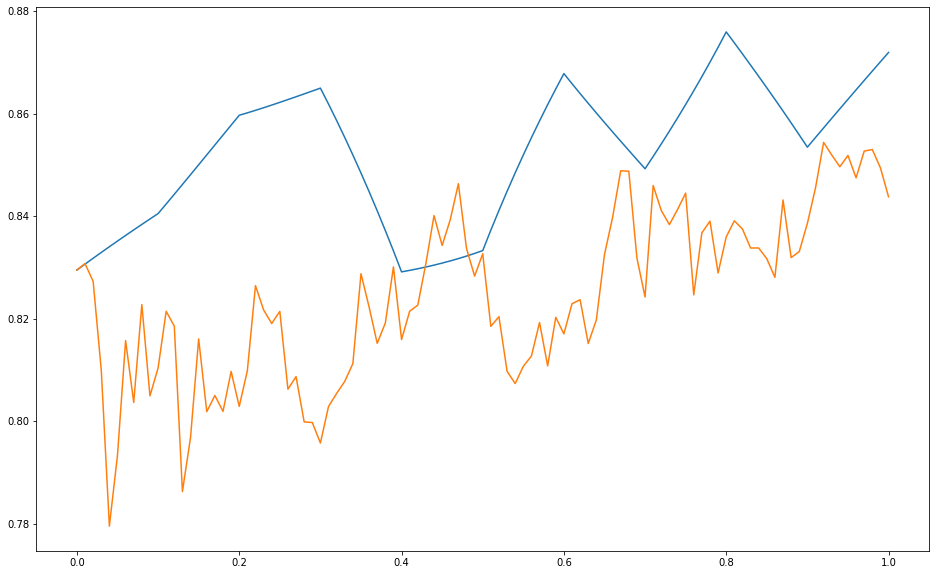

In [ ]:
x,v = manager.get_result('test0',metric='f1')
v = v[0].squeeze()
plt.figure(num=1, figsize=(16, 10))
plt.plot(x,v)
x,v = manager.get_result('test1',metric='f1')
v = v[0].squeeze()
plt.plot(x,v)

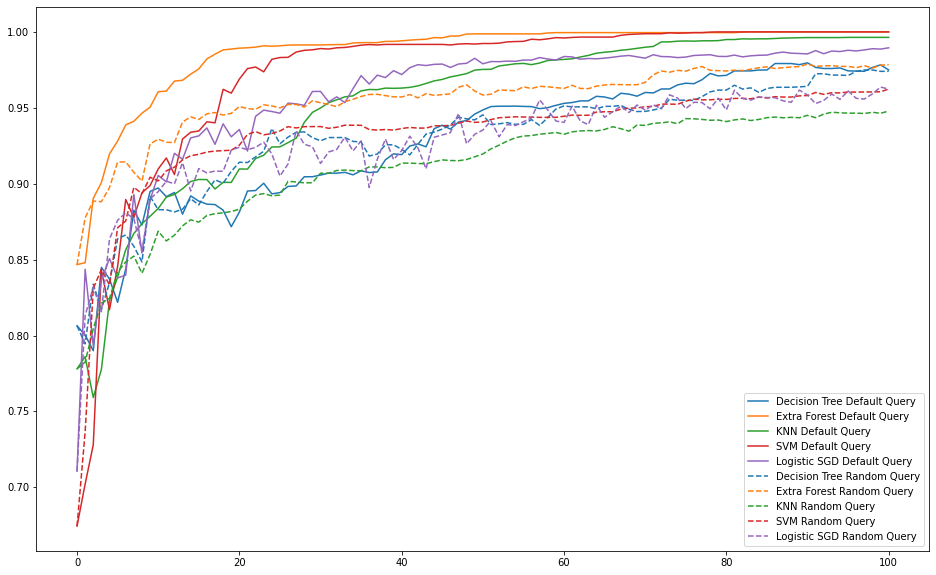

In [ ]:
#manager.run_experiment_test('test')
#manager.run_experiment_test('testRandom',random=True)

V = manager.get_result("test",metric='f1',).squeeze()
v = manager.get_result("testRandom",metric='f1',).squeeze()
q = np.arange(101)
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))

for a,b in zip(V,names):
  plt.plot(q,a,label=b+" Default Query")

plt.gca().set_prop_cycle(None)

for a,b in zip(v,names):
  plt.plot(q,a,label=b+" Random Query",linestyle='--')

plt.legend()
plt.show()

## Dataset 2: Credit

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
!unzip SouthGermanCredit.zip
!rm codetable.txt read_SouthGermanCredit.R SouthGermanCredit.zip

--2020-08-27 15:24:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13130 (13K) [application/x-httpd-php]
Saving to: ‘SouthGermanCredit.zip.1’

SouthGermanCredit.z 100%[===================>]  12.82K  --.-KB/s    in 0s      

2020-08-27 15:24:16 (85.7 MB/s) - ‘SouthGermanCredit.zip.1’ saved [13130/13130]

Archive:  SouthGermanCredit.zip
 bunzipping: codetable.txt           
 bunzipping: read_SouthGermanCredit.R  
replace SouthGermanCredit.asc? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
credit = pd.read_csv('SouthGermanCredit.asc',delimiter=' ',header=0,names=['Status','Duration','CreditHistory','Purpose','Amount','Savings','EmploymentDuration','InstallmentRate','MarriageStatus','OtherDebtors','PresentResidence','Property','Age','OtherInstallmentPlans','Housing','NumberCredits','Job','PeopleLiable','Phone','ForeignWorker','CreditRisk'])

In [ ]:
credit.head()

,Status,Duration,CreditHistory,Purpose,Amount,Savings,EmploymentDuration,InstallmentRate,MarriageStatus,OtherDebtors,PresentResidence,Property,Age,OtherInstallmentPlans,Housing,NumberCredits,Job,PeopleLiable,Phone,ForeignWorker,CreditRisk
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1,1


In [ ]:
credit.isna().sum()

Status                   0
Duration                 0
CreditHistory            0
Purpose                  0
Amount                   0
Savings                  0
EmploymentDuration       0
InstallmentRate          0
MarriageStatus           0
OtherDebtors             0
PresentResidence         0
Property                 0
Age                      0
OtherInstallmentPlans    0
Housing                  0
NumberCredits            0
Job                      0
PeopleLiable             0
Phone                    0
ForeignWorker            0
CreditRisk               0
dtype: int64

In [ ]:
num_cols = ['Duration','Amount','Age','CreditRisk']
credit[credit.columns.difference(num_cols)] = credit[credit.columns.difference(num_cols)].astype('category')

In [ ]:
[credit.columns.get_loc(c) for c in num_cols if c in credit]

[1, 4, 12, 20]

In [ ]:
X = pd.get_dummies(credit.drop(columns=['CreditRisk'])).values
y = credit.CreditRisk.values

In [ ]:
manager = ExperimentManager(X,y,'Credit')

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape you

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape you

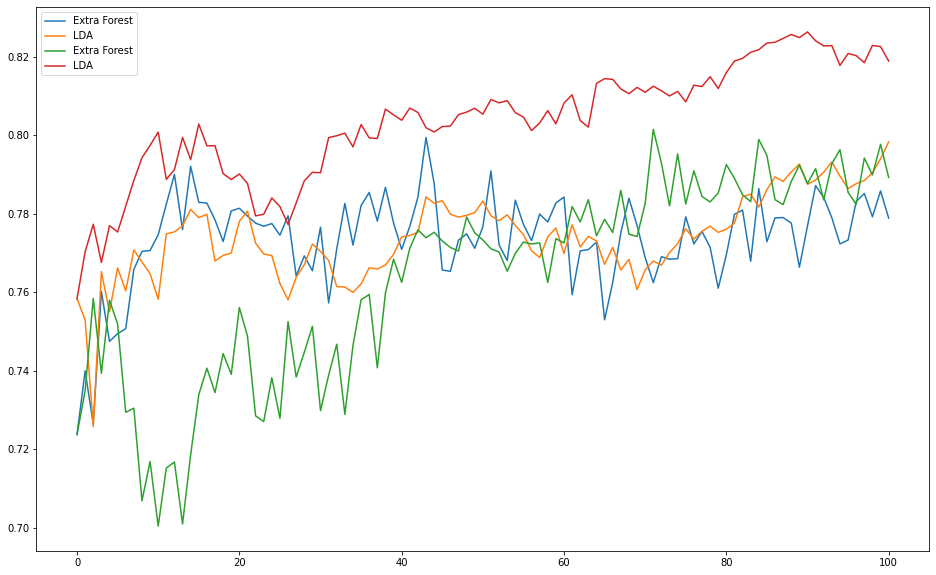

In [ ]:
manager.run_experiment_test('test')
manager.run_experiment_test('testRandom',random=True)
V = manager.get_result("test",metric='f1',).squeeze()
v = manager.get_result("testRandom",metric='f1',).squeeze()
q = np.arange(101)
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,v[0],label=names[0])
plt.plot(q,v[1],label=names[1])
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
#plt.plot(q,V[2],label=names[2])
plt.legend()
plt.show()

## Dataset 2: UCI

In [ ]:
!mkdir uci
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt -P /content/uci

mkdir: cannot create directory ‘uci’: File exists
--2020-08-31 11:28:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46400 (45K) [application/x-httpd-php]
Saving to: ‘/content/uci/data_banknote_authentication.txt’

data_banknote_authe 100%[===================>]  45.31K   154KB/s    in 0.3s    

2020-08-31 11:28:50 (154 KB/s) - ‘/content/uci/data_banknote_authentication.txt’ saved [46400/46400]



In [ ]:
uci = pd.read_csv('uci/data_banknote_authentication.txt',names=['WaveletVariance','WaveletSkewness','WaveletKurtosis','ImageEntropy','Class'])

In [ ]:
uci.describe()

,WaveletVariance,WaveletSkewness,WaveletKurtosis,ImageEntropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


There are no missing values

In [ ]:
uci.isna().sum()

WaveletVariance    0
WaveletSkewness    0
WaveletKurtosis    0
ImageEntropy       0
Class              0
dtype: int64

Class values are more balanced

In [ ]:
pd.value_counts(uci.Class)

0    762
1    610
Name: Class, dtype: int64

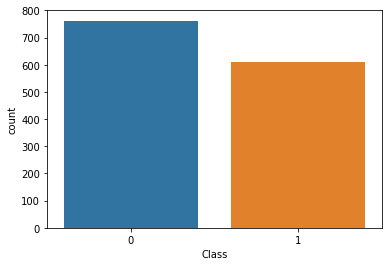

In [ ]:
sns.countplot('Class',data=uci)

###Experimental Setup

All features need to be scaled. Scaling will take place inside the CV folds



In [ ]:
X = uci.drop(columns=['Class']).values
y = uci.Class.values

manager = ExperimentManager(X,y,'UCI',scalable_cols='all')

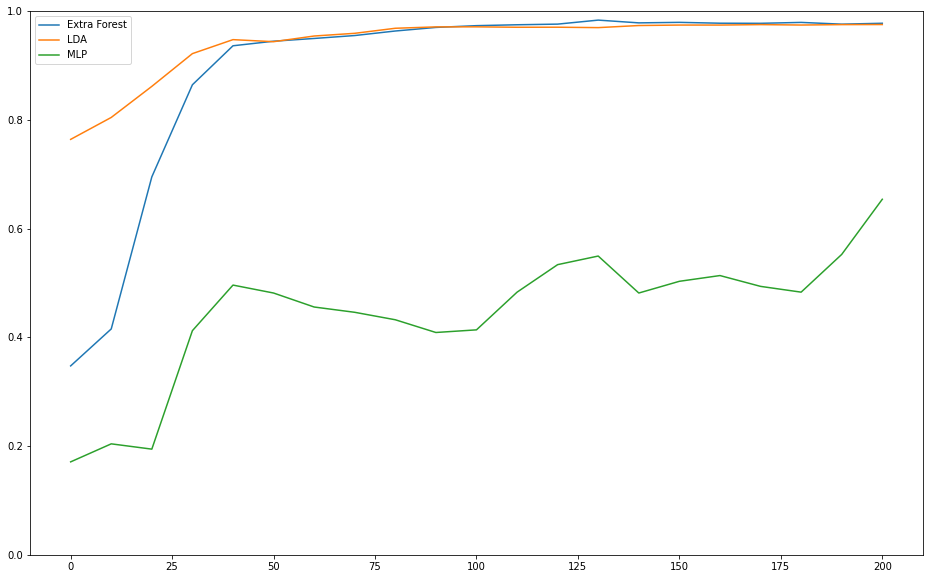

In [ ]:
manager.run_experiment_test('random')
V = manager.get_result("random",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
manager.run_experiment_test('uncertainty')
V = manager.get_result("uncertainty",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

KeyboardInterrupt: ignored

In [ ]:
manager.run_experiment_test('consensus')
V = manager.get_result("consensus",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
manager.run_experiment_test('disagreement')
V = manager.get_result("disagreement",metric='f1',).squeeze()
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
plt.figure(num=1, figsize=(16, 10))
plt.plot(q,V[0],label=names[0])
plt.plot(q,V[1],label=names[1])
plt.plot(q,V[2],label=names[2])
plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
q = np.arange(manager.K)*manager.batch
names = manager.base_model_names
for i,c,n in zip(range(3),['C0','C1','C2'],names):
  plt.figure(num=1, figsize=(16, 10))
  for e, l in zip(['random','uncertainty','consensus','disagreement'],['-','--',':','-.']):
    V = manager.get_result(e,metric='f1',).squeeze()
    plt.plot(q,V[i],color=c,linestyle=l, label=e.title(),linewidth=4)

    #plt.plot(q,V[1],color='C1',linestyle=l)
    #plt.plot(q,V[2],color='C2',linestyle=l)
  plt.ylim([0,1])
  plt.legend(prop={'size': 20})
  plt.title(n)
  plt.show()